In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

from datetime import timedelta
from datetime import datetime
from datetime import date
from datetime import time

from tqdm import tqdm
import scipy.stats as st

In [4]:
df_transf0 = pd.read_csv("DATA_RESULTS/df_RBCT_extractedFeat_NoImputated_tau9_v3.csv")
df_transf0.drop(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
# df_RBCT_extractedFeat_medImputated_tau9_v3
# df_RBCT_extractedFeat_NoImputated_tau9_v3.csv

In [5]:
df_transf0.drop_duplicates(inplace=True)
df_transf0.shape

(22874, 49)

# Eliminated the patients having pre-transfusion SF, Hb, SpO2, PF missing


In [6]:
print(df_transf0[['med_spo2_beforeT', 'med_Hb_beforeT', 'med_SF_beforeT','med_PF_beforeT']].isnull().all(axis=1).sum())

df_transf = df_transf0[~df_transf0[['med_spo2_beforeT', 'med_Hb_beforeT', 'med_SF_beforeT','med_PF_beforeT']].isnull().all(axis=1)]
df_transf.reset_index(drop=True, inplace=True)
print(df_transf.shape)

print(len(df_transf0.pat_id.unique()), len(df_transf0.csn.unique()), len(df_transf.pat_id.unique()), len(df_transf.csn.unique()))

7
(22867, 49)
13051 14765 13045 14758


In [8]:
df_transf[df_transf.med_spo2_beforeT.isnull()].shape

(110, 49)

In [9]:
df_transf.med_SF_beforeT.isnull().sum()

4151

In [10]:
df_transf.columns

Index(['pat_id', 'PAT_ID', 'csn', 'encntr_id', 'dispense_dt_tm',
       'estimated_transfusion_dt_tm', 'product_cd_disp', 'bed_location_start',
       'bed_location_end', 'product_cat_cd_disp', 'orig_volume', 'year',
       'hospital_service', 'Arb', 'Tcount_7d', 'discharge_to', 'age', 'gender',
       'race', 'ethnicity', 'Hb', 'med_spo2_beforeT', 'med_Hb_beforeT',
       'med_SF_beforeT', 'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2',
       'MSPO2_afterT3', 'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3',
       'MSF_afterT1', 'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1',
       'MPF_afterT2', 'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3',
       'del_Hb_1', 'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3',
       'del_PF_1', 'del_PF_2', 'del_PF_3'],
      dtype='object')

In [11]:
df_transf.loc[:,'Hb':].max()

Hb                    19.800000
med_spo2_beforeT     100.000000
med_Hb_beforeT        19.400000
med_SF_beforeT       476.190476
med_PF_beforeT      2366.666667
MSPO2_afterT1        100.000000
MSPO2_afterT2        100.000000
MSPO2_afterT3        100.000000
MHB_afterT1           17.400000
MHB_afterT2           17.400000
MHB_afterT3           17.300000
MSF_afterT1          476.190476
MSF_afterT2          476.190476
MSF_afterT3          476.190476
MPF_afterT1         2371.428571
MPF_afterT2         2371.428571
MPF_afterT3         2371.428571
del_SPO2_1            93.000000
del_SPO2_2            92.000000
del_SPO2_3            92.000000
del_Hb_1              10.600000
del_Hb_2              10.700000
del_Hb_3              10.300000
del_SF_1             376.190476
del_SF_2             378.190476
del_SF_3             376.190476
del_PF_1            1344.583333
del_PF_2            1383.333333
del_PF_3            1383.333333
dtype: float64

In [12]:
df_transf['MSF_beforeT']=df_transf['med_SF_beforeT']
# df_transf.pop('med_SF_beforeT')
df_transf['MSF_beforeT']

/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/2981157439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['MSF_beforeT']=df_transf['med_SF_beforeT']


0        476.190476
1        461.904762
2        466.666667
3        285.714286
4        147.063492
            ...    
22862    466.666667
22863    323.750000
22864     99.000000
22865    476.190476
22866    350.000000
Name: MSF_beforeT, Length: 22867, dtype: float64

In [13]:
df_transf['MSF_beforeT'].isnull().sum()

4151

In [14]:
(df_transf[['MSF_beforeT','MSF_afterT1']].T.isnull().sum()==2).sum()

3842

## Delta SF vs baseline Hb for 4 pre-SF ranges and 3 time-horizons

four groups of SF: 1-143, 144-235, 236-315, >315

In [15]:
cond1 =  df_transf['MSF_beforeT']>=1 
cond2 = df_transf['MSF_beforeT']<=143
cond12 = cond1 & cond2
# MSFbaseline_gp1 = df_transf['MSF_beforeT'][cond12]
MSFbaseline_gp1 =  pd.Series(np.where(cond12, df_transf['MSF_beforeT'], None))

In [16]:
# MSFbaseline_gp2[~MSFbaseline_gp2.isnull()]
cond12.shape, MSFbaseline_gp1.shape

((22867,), (22867,))

In [17]:
MSFbaseline_gp1.isnull().sum()

20940

In [18]:
del cond1, cond2, cond12

In [19]:
cond1 =  df_transf['MSF_beforeT']>=144
cond2 = df_transf['MSF_beforeT']<=235
cond12 = cond1 & cond2
# MSFbaseline_gp2 = df_transf['MSF_beforeT'][cond12]
MSFbaseline_gp2 =  pd.Series(np.where(cond12, df_transf['MSF_beforeT'], None))

In [20]:
del cond1, cond2, cond12
cond1 =  df_transf['MSF_beforeT']>=236
cond2 = df_transf['MSF_beforeT']<=315
cond12 = cond1 & cond2
# MSFbaseline_gp3 = df_transf['MSF_beforeT'][cond12]
MSFbaseline_gp3 =  pd.Series(np.where(cond12, df_transf['MSF_beforeT'], None))

In [21]:
del cond1, cond2, cond12
cond12 =  df_transf['MSF_beforeT']>315 
# MSFbaseline_gp4 = df_transf['MSF_beforeT'][cond12]
MSFbaseline_gp4 =  pd.Series(np.where(cond12, df_transf['MSF_beforeT'], None))

In [22]:
# df_transf['MSF_afterT1']#
zx = df_transf['MSF_afterT1'] - MSFbaseline_gp1
zx.isnull().sum()

21129

In [23]:
(~MSFbaseline_gp1.isnull()).sum() + (~MSFbaseline_gp2.isnull()).sum() +(~MSFbaseline_gp3.isnull()).sum()+(~MSFbaseline_gp4.isnull()).sum()

18700

In [24]:
len(df_transf['MSF_afterT1'])

22867

In [25]:
len(MSFbaseline_gp1)

22867

In [26]:
zx

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
22862    NaN
22863    NaN
22864   -2.0
22865    NaN
22866    NaN
Length: 22867, dtype: object

In [27]:
df_transf['del_SF_1a']=df_transf['MSF_afterT1'] - MSFbaseline_gp1
df_transf['del_SF_2a']=df_transf['MSF_afterT2'] - MSFbaseline_gp1
df_transf['del_SF_3a']=df_transf['MSF_afterT3'] - MSFbaseline_gp1

/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/1527135969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_1a']=df_transf['MSF_afterT1'] - MSFbaseline_gp1
/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/1527135969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_2a']=df_transf['MSF_afterT2'] - MSFbaseline_gp1
/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/1527135969.py:3: SettingWithCopyWarning: 
A value is trying to

In [28]:
df_transf['del_SF_1b']=df_transf['MSF_afterT1'] - MSFbaseline_gp2
df_transf['del_SF_2b']=df_transf['MSF_afterT2'] - MSFbaseline_gp2
df_transf['del_SF_3b']=df_transf['MSF_afterT3'] - MSFbaseline_gp2

/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/3867128395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_1b']=df_transf['MSF_afterT1'] - MSFbaseline_gp2
/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/3867128395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_2b']=df_transf['MSF_afterT2'] - MSFbaseline_gp2
/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/3867128395.py:3: SettingWithCopyWarning: 
A value is trying to

In [29]:
df_transf['del_SF_1c']=df_transf['MSF_afterT1'] - MSFbaseline_gp3
df_transf['del_SF_2c']=df_transf['MSF_afterT2'] - MSFbaseline_gp3
df_transf['del_SF_3c']=df_transf['MSF_afterT3'] - MSFbaseline_gp3

/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/942912688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_1c']=df_transf['MSF_afterT1'] - MSFbaseline_gp3
/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/942912688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_2c']=df_transf['MSF_afterT2'] - MSFbaseline_gp3
/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/942912688.py:3: SettingWithCopyWarning: 
A value is trying to be

In [30]:
df_transf['del_SF_1d']=df_transf['MSF_afterT1'] - MSFbaseline_gp4
df_transf['del_SF_2d']=df_transf['MSF_afterT2'] - MSFbaseline_gp4
df_transf['del_SF_3d']=df_transf['MSF_afterT3'] - MSFbaseline_gp4

/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/3766971520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_1d']=df_transf['MSF_afterT1'] - MSFbaseline_gp4
/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/3766971520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transf['del_SF_2d']=df_transf['MSF_afterT2'] - MSFbaseline_gp4
/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/3766971520.py:3: SettingWithCopyWarning: 
A value is trying to

In [31]:
MSFbaseline_gp1

0        None
1        None
2        None
3        None
4        None
         ... 
22862    None
22863    None
22864    99.0
22865    None
22866    None
Length: 22867, dtype: object

In [32]:
df_transf[['del_SF_1a', 'MSF_afterT1']]

,del_SF_1a,MSF_afterT1
0,NaN,476.190476
1,NaN,459.523810
2,NaN,466.666667
3,NaN,285.714286
4,NaN,235.000000
...,...,...
22862,NaN,466.666667
22863,NaN,152.500000
22864,-2.0,97.000000
22865,NaN,476.190476


(-400.0, 400.0)

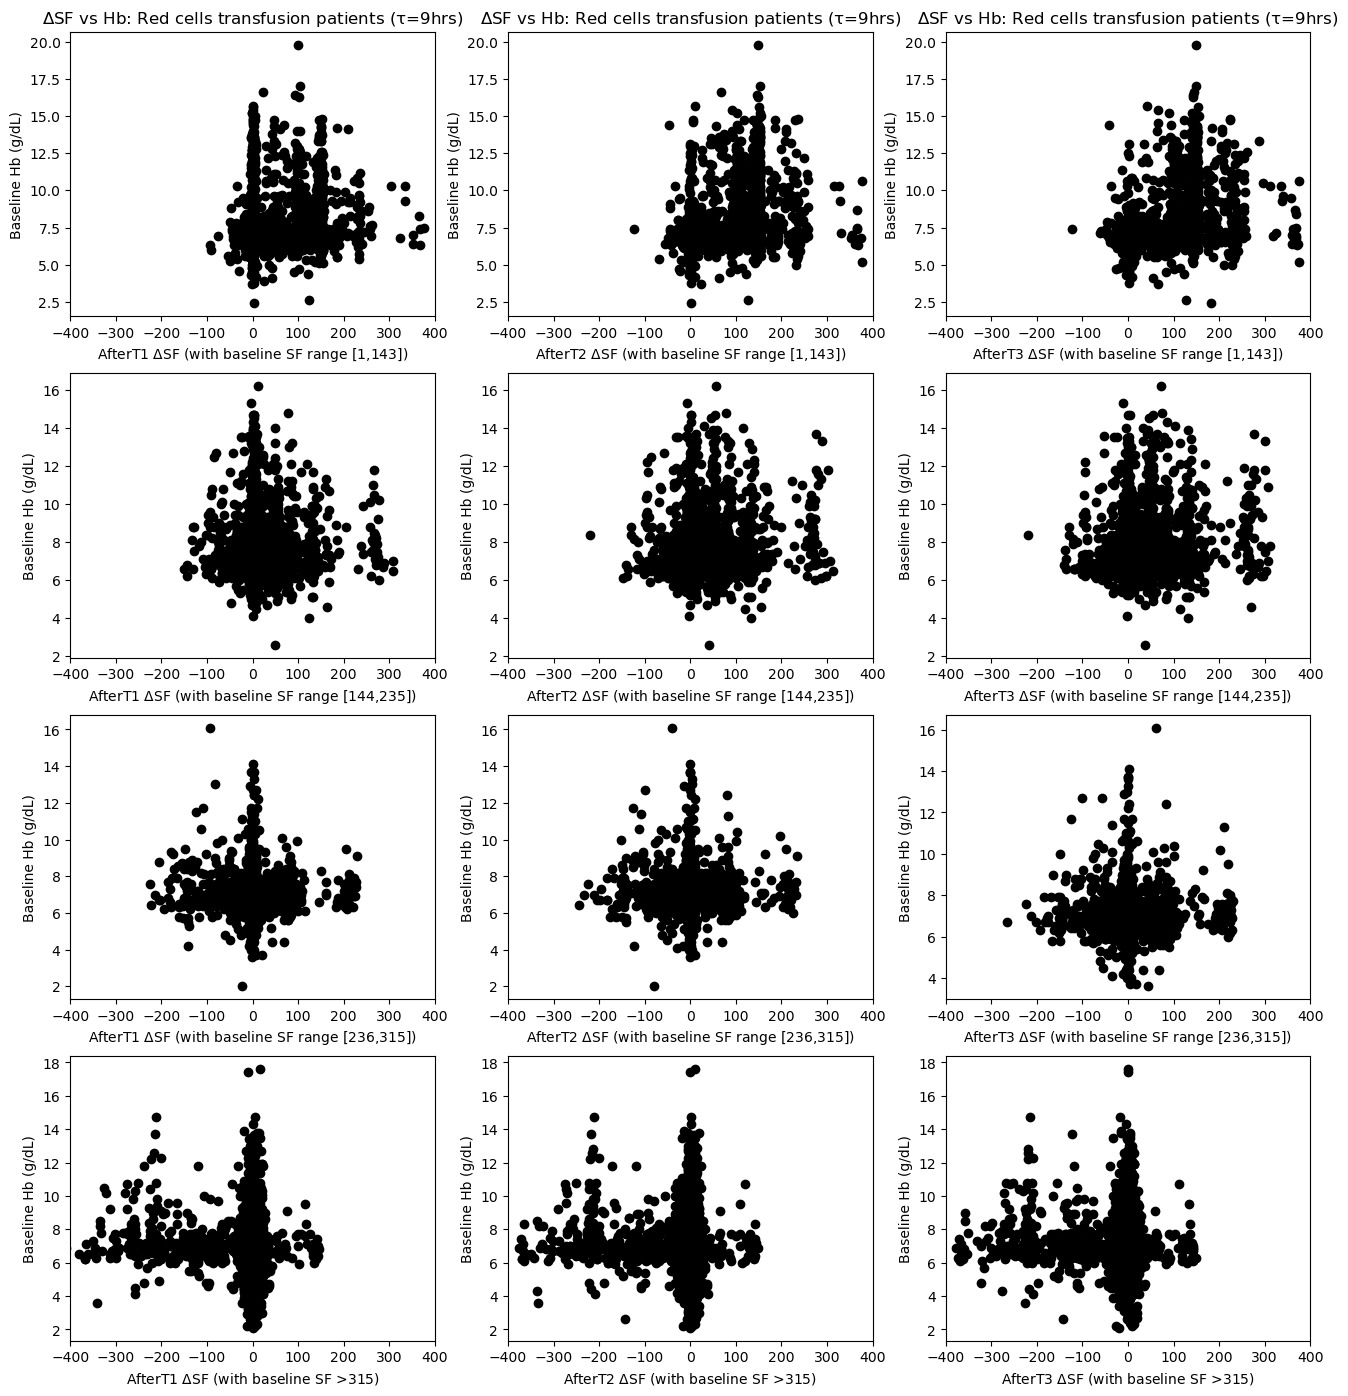

In [33]:
fig, axs = plt.subplots(4, 3, figsize =(16, 17))

axs[0,0].scatter(df_transf['del_SF_1a'], df_transf['Hb'],color='black')
axs[0,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [1,143])')
axs[0,0].set_ylabel('Baseline Hb (g/dL)')
axs[0,0].set_xlim([-400, 400])

axs[0,1].scatter(df_transf['del_SF_2a'], df_transf['Hb'],color='black')
axs[0,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [1,143])')
axs[0,1].set_ylabel('Baseline Hb (g/dL)')
axs[0,1].set_xlim([-400, 400])

axs[0,2].scatter(df_transf['del_SF_3a'], df_transf['Hb'],color='black')
axs[0,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [1,143])')
axs[0,2].set_ylabel('Baseline Hb (g/dL)')
axs[0,2].set_xlim([-400, 400])

axs[1,0].scatter(df_transf['del_SF_1b'], df_transf['Hb'],color='black')
#axs[1,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [144,235])')
axs[1,0].set_ylabel('Baseline Hb (g/dL)')
axs[1,0].set_xlim([-400, 400])

axs[1,1].scatter(df_transf['del_SF_2b'], df_transf['Hb'],color='black')
#axs[1,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [144,235])')
axs[1,1].set_ylabel('Baseline Hb (g/dL)')
axs[1,1].set_xlim([-400, 400])

axs[1,2].scatter(df_transf['del_SF_3b'], df_transf['Hb'],color='black')
#axs[1,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [144,235])')
axs[1,2].set_ylabel('Baseline Hb (g/dL)')
axs[1,2].set_xlim([-400, 400])

axs[2,0].scatter(df_transf['del_SF_1c'], df_transf['Hb'],color='black')
#axs[2,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [236,315])')
axs[2,0].set_ylabel('Baseline Hb (g/dL)')
axs[2,0].set_xlim([-400, 400])

axs[2,1].scatter(df_transf['del_SF_2c'], df_transf['Hb'],color='black')
#axs[2,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [236,315])')
axs[2,1].set_ylabel('Baseline Hb (g/dL)')
axs[2,1].set_xlim([-400, 400])

axs[2,2].scatter(df_transf['del_SF_3c'], df_transf['Hb'],color='black')
#axs[2,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [236,315])')
axs[2,2].set_ylabel('Baseline Hb (g/dL)')
axs[2,2].set_xlim([-400, 400])

axs[3,0].scatter(df_transf['del_SF_1d'], df_transf['Hb'],color='black')
#axs[3,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF >315)')
axs[3,0].set_ylabel('Baseline Hb (g/dL)')
axs[3,0].set_xlim([-400, 400])

axs[3,1].scatter(df_transf['del_SF_2d'], df_transf['Hb'],color='black')
#axs[3,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF >315)')
axs[3,1].set_ylabel('Baseline Hb (g/dL)')
axs[3,1].set_xlim([-400, 400])

axs[3,2].scatter(df_transf['del_SF_3d'], df_transf['Hb'],color='black')
#axs[3,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF >315)')
axs[3,2].set_ylabel('Baseline Hb (g/dL)')
axs[3,2].set_xlim([-400, 400])

# plt.savefig('DATA_RESULTS_REV1/delSFvsHb_RedCellsT.png',format="png", bbox_inches="tight", dpi=300)

**Analysis: (1) % improvement in SF (for baseline SF 1-100 and >300) with 95% CI, (b) Association b/w Hb vs delSF**

In [34]:
#for baseline SF 1-143
dSF1a = df_transf['del_SF_1a'][~df_transf['del_SF_1a'].isnull()]
dSF2a = df_transf['del_SF_2a'][~df_transf['del_SF_2a'].isnull()]
dSF3a = df_transf['del_SF_3a'][~df_transf['del_SF_3a'].isnull()]

#calculating the 95% confidence interval of the mean of array dSF1a
CI1a = st.t.interval(0.95, len(dSF1a)-1, loc=dSF1a.mean(), scale=st.sem(dSF1a, nan_policy='omit'))
CI2a = st.t.interval(0.95, len(dSF2a)-1, loc=dSF2a.mean(), scale=st.sem(dSF2a, nan_policy='omit'))
CI3a = st.t.interval(0.95, len(dSF3a)-1, loc=dSF3a.mean(), scale=st.sem(dSF3a, nan_policy='omit'))
print(f'For baseline SF (1-143), mean increase in SF for T1 with 95% CI: ',dSF1a.mean(),CI1a)
print(f'For baseline SF (1-143), mean increase in SF for T2 with 95% CI: ',dSF2a.mean(),CI2a)
print(f'For baseline SF (1-143), mean increase in SF for T3 with 95% CI: ',dSF3a.mean(),CI3a)


q1q3_1a = dSF1a.quantile(0.25), dSF1a.quantile(0.75)
q1q3_2a = dSF2a.quantile(0.25), dSF2a.quantile(0.75)
q1q3_3a = dSF3a.quantile(0.25), dSF3a.quantile(0.75)

m_s_1a = dSF1a.mean()-dSF1a.std(), dSF1a.mean()+dSF1a.std()
m_s_2a = dSF2a.mean()-dSF2a.std(), dSF2a.mean()+dSF2a.std()
m_s_3a = dSF3a.mean()-dSF3a.std(), dSF3a.mean()+dSF3a.std()

print(f"Mean increment in SF for T1: {dSF1a.mean():.2f} ({m_s_1a[0]:.2f}, {m_s_1a[1]:.2f})")
print(f"Mean increment in SF for T2: {dSF2a.mean():.2f} ({m_s_2a[0]:.2f}, {m_s_2a[1]:.2f})")
print(f"Mean increment in SF for T3: {dSF3a.mean():.2f} ({m_s_3a[0]:.2f}, {m_s_3a[1]:.2f})")

For baseline SF (1-143), mean increase in SF for T1 with 95% CI:  63.899349414399126 (60.40027763355943, 67.39842119523883)
For baseline SF (1-143), mean increase in SF for T2 with 95% CI:  90.3124579445772 (86.58409937679659, 94.04081651235782)
For baseline SF (1-143), mean increase in SF for T3 with 95% CI:  103.61733501955109 (99.76578926006002, 107.46888077904217)
Mean increment in SF for T1: 63.90 (-10.48, 138.27)
Mean increment in SF for T2: 90.31 (13.08, 167.55)
Mean increment in SF for T3: 103.62 (25.69, 181.55)


In [35]:
def mean_CI(data):
    # Step 1: Remove NaN values
    data = np.asarray(data, dtype='float')
    clean_data = data[~np.isnan(data)]

    # Step 2: Calculate the mean
    mean = np.mean(clean_data)

    # Step 3: Calculate the standard error of the mean (SE)
    std_dev = np.std(clean_data, ddof=1)  # Sample standard deviation
    n = len(clean_data)  # Sample size
    se = std_dev / np.sqrt(n)

    # Step 4: Calculate the t-value for the 95% confidence interval
    confidence_level = 0.99
    alpha = 1 - confidence_level
    t_value = st.t.ppf(1 - alpha / 2, df=n-1)  # Two-tailed test

    # Step 5: Compute the confidence interval
    ci_lower = mean - t_value * se
    ci_upper = mean + t_value * se
    CI = (ci_lower, ci_upper)
    return mean, CI

xz = pd.Series([12.4, 15.6, np.nan, 22.1, 14.7, 19.3, 15, 18.5])
mm, cii = mean_CI(dSF2a)
print(f"Mean: {mm:.2f}")
print(f"95% Confidence Interval: ({cii[0]:.2f}, {cii[1]:.2f})")

Mean: 90.31
95% Confidence Interval: (85.41, 95.21)


In [36]:
dSF1a.median(), np.nanmedian(dSF1a)

(30.54464285714286, 30.54464285714286)

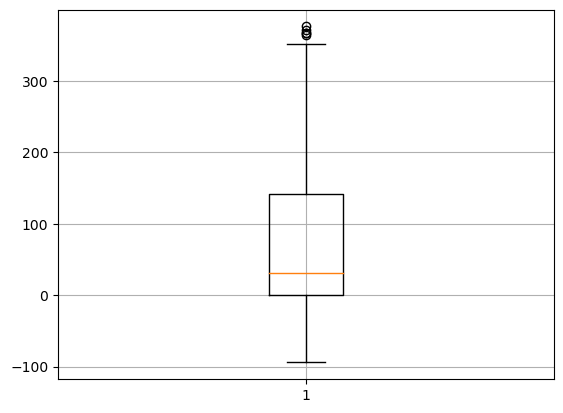

In [37]:
plt.boxplot(dSF1a)
plt.grid(True)

In [38]:
#for baseline SF 143-235
dSF1b = df_transf['del_SF_1b'][~df_transf['del_SF_1b'].isnull()]
dSF2b = df_transf['del_SF_2b'][~df_transf['del_SF_2b'].isnull()]
dSF3b = df_transf['del_SF_3b'][~df_transf['del_SF_3b'].isnull()]

#calculating the 95% confidence interval of the mean of array dSF1a
CI1b = st.t.interval(0.95, len(dSF1b)-1, loc=dSF1b.mean(), scale=st.sem(dSF1b, nan_policy='omit'))
CI2b = st.t.interval(0.95, len(dSF2b)-1, loc=dSF2b.mean(), scale=st.sem(dSF2b, nan_policy='omit'))
CI3b = st.t.interval(0.95, len(dSF3b)-1, loc=dSF2b.mean(), scale=st.sem(dSF3b, nan_policy='omit'))


q1q3_1b = dSF1b.quantile(0.25), dSF1b.quantile(0.75)
q1q3_2b = dSF2b.quantile(0.25), dSF2b.quantile(0.75)
q1q3_3b = dSF3b.quantile(0.25), dSF3b.quantile(0.75)

m_s_1b = dSF1b.mean()-dSF1b.std(), dSF1b.mean()+dSF1b.std()
m_s_2b = dSF2b.mean()-dSF2b.std(), dSF2b.mean()+dSF2b.std()
m_s_3b = dSF3b.mean()-dSF3b.std(), dSF3b.mean()+dSF3b.std()

print(f"Mean increment in SF for T1: {dSF1b.mean():.2f} ({m_s_1b[0]:.2f}, {m_s_1b[1]:.2f})")
print(f"Mean increment in SF for T2: {dSF2b.mean():.2f} ({m_s_2b[0]:.2f}, {m_s_2b[1]:.2f})")
print(f"Mean increment in SF for T3: {dSF3b.mean():.2f} ({m_s_3b[0]:.2f}, {m_s_3b[1]:.2f})")

Mean increment in SF for T1: 19.13 (-33.64, 71.90)
Mean increment in SF for T2: 29.73 (-33.46, 92.93)
Mean increment in SF for T3: 35.59 (-32.31, 103.48)


In [39]:
#for baseline SF 236-315
dSF1c = df_transf['del_SF_1c'][~df_transf['del_SF_1c'].isnull()]
dSF2c = df_transf['del_SF_2c'][~df_transf['del_SF_2c'].isnull()]
dSF3c = df_transf['del_SF_3c'][~df_transf['del_SF_3c'].isnull()]

#calculating the 95% confidence interval of the mean of array dSF1a
CI1c = st.t.interval(0.95, len(dSF1c)-1, loc=dSF1c.mean(), scale=st.sem(dSF1c, nan_policy='omit'))
CI2c = st.t.interval(0.95, len(dSF2c)-1, loc=dSF2c.mean(), scale=st.sem(dSF2c, nan_policy='omit'))
CI3c = st.t.interval(0.95, len(dSF3c)-1, loc=dSF2c.mean(), scale=st.sem(dSF3c, nan_policy='omit'))


q1q3_1c = dSF1c.quantile(0.25), dSF1c.quantile(0.75)
q1q3_2c = dSF2c.quantile(0.25), dSF2c.quantile(0.75)
q1q3_3c = dSF3c.quantile(0.25), dSF3c.quantile(0.75)

m_s_1c = dSF1c.mean()-dSF1c.std(), dSF1c.mean()+dSF1c.std()
m_s_2c = dSF2c.mean()-dSF2c.std(), dSF2c.mean()+dSF2c.std()
m_s_3c = dSF3c.mean()-dSF3c.std(), dSF3c.mean()+dSF3c.std()

print(f"Mean increment in SF for T1: {dSF1c.mean():.2f} ({m_s_1c[0]:.2f}, {m_s_1c[1]:.2f})")
print(f"Mean increment in SF for T2: {dSF2c.mean():.2f} ({m_s_2c[0]:.2f}, {m_s_2c[1]:.2f})")
print(f"Mean increment in SF for T3: {dSF3c.mean():.2f} ({m_s_3c[0]:.2f}, {m_s_3c[1]:.2f})")

Mean increment in SF for T1: 1.63 (-41.93, 45.18)
Mean increment in SF for T2: 4.19 (-44.77, 53.15)
Mean increment in SF for T3: 6.45 (-45.41, 58.32)


In [40]:
#for baseline SF >315
dSF1d = df_transf['del_SF_1d'][~df_transf['del_SF_1d'].isnull()]
dSF2d = df_transf['del_SF_2d'][~df_transf['del_SF_2d'].isnull()]
dSF3d = df_transf['del_SF_3d'][~df_transf['del_SF_3d'].isnull()]

#calculating the 95% confidence interval of the mean of array dSF1a
CI1d = st.t.interval(0.95, len(dSF1d)-1, loc=dSF1d.mean(), scale=st.sem(dSF1d, nan_policy='omit'))
CI2d = st.t.interval(0.95, len(dSF2d)-1, loc=dSF2d.mean(), scale=st.sem(dSF2d, nan_policy='omit'))
CI3d = st.t.interval(0.95, len(dSF3d)-1, loc=dSF2d.mean(), scale=st.sem(dSF3d, nan_policy='omit'))
print(f'For baseline SF>315, mean increase in SF for T1 with 95% CI: ',dSF1d.mean(),CI1d)
print(f'For baseline SF>315, mean increase in SF for T2 with 95% CI: ',dSF2d.mean(),CI2d)
print(f'For baseline SF>315, mean increase in SF for T3 with 95% CI: ',dSF3d.mean(),CI3d)


q1q3_1d = dSF1d.quantile(0.25), dSF1d.quantile(0.75)
q1q3_2d = dSF2d.quantile(0.25), dSF2d.quantile(0.75)
q1q3_3d = dSF3d.quantile(0.25), dSF3d.quantile(0.75)

m_s_1d = dSF1d.mean()-dSF1d.std(), dSF1d.mean()+dSF1d.std()
m_s_2d = dSF2d.mean()-dSF2d.std(), dSF2d.mean()+dSF2d.std()
m_s_3d = dSF3d.mean()-dSF3d.std(), dSF3d.mean()+dSF3d.std()

print(f"Mean increment in SF for T1: {dSF1d.mean():.2f} ({m_s_1d[0]:.2f}, {m_s_1d[1]:.2f})")
print(f"Mean increment in SF for T2: {dSF2d.mean():.2f} ({m_s_2d[0]:.2f}, {m_s_2d[1]:.2f})")
print(f"Mean increment in SF for T3: {dSF3d.mean():.2f} ({m_s_3d[0]:.2f}, {m_s_3d[1]:.2f})")

For baseline SF>315, mean increase in SF for T1 with 95% CI:  -5.677730255385318 (-6.364609813155031, -4.990850697615604)
For baseline SF>315, mean increase in SF for T2 with 95% CI:  -7.108306549590251 (-7.855613290192223, -6.3609998089882795)
For baseline SF>315, mean increase in SF for T3 with 95% CI:  -8.32039643554023 (-7.9304960217775795, -6.286117077402923)
Mean increment in SF for T1: -5.68 (-41.01, 29.65)
Mean increment in SF for T2: -7.11 (-44.86, 30.65)
Mean increment in SF for T3: -8.32 (-48.73, 32.09)


In [41]:
df_transf['del_SF_1d'].max()

145.63492063492066

In [42]:
a1 = np.array([1,2,3,np.nan, np.nan,5])
a2 = np.array([9,np.nan,8,np.nan, np.nan,np.nan])

In [43]:
cond = ~np.isnan(a1+a2)
a1 = a1[cond]
a2 = a2[cond]
a1, a2

(array([1., 3.]), array([9., 8.]))

In [44]:
a1

array([1., 3.])

In [45]:
from sklearn.metrics import r2_score

In [46]:
def r2Score(y, f): #y:actual, f:predicted
    # SSres = sum(map(lambda x: (x[0]-x[1])**2, zip(y, f)))
    # SStot = sum([(x-np.mean(y))**2 for x in y])
    # r2 = 1-(SSres/SStot)
    
    cond = ~np.isnan(np.array(y+f, dtype='float'))
    y = y[cond]
    f = f[cond]
    
    
    ssres = sum((y - f)**2)
    sstot = sum((y-np.mean(y))**2)
    r2 = 1-(ssres/sstot)
    
    return r2

In [47]:
#R2 (R2 = 1- SSres/SStotal) of delta SF vs baseline Hb 
id1a = np.array(dSF1a.index)
mdSF1a = np.array(dSF1a)    #[~np.isnan(MSFbaseline_gp1)]
mHb1a = np.array(df_transf['Hb'][id1a])
r2_1a = r2Score(mdSF1a, mHb1a)

id2a = np.array(dSF2a.index)
mdSF2a = np.array(dSF2a)    
mHb2a = np.array(df_transf['Hb'][id2a])
r2_2a = r2Score(mdSF2a, mHb2a)

id3a = np.array(dSF3a.index)
mdSF3a = np.array(dSF3a)    
mHb3a = np.array(df_transf['Hb'][id3a])
r2_3a = r2Score(mdSF3a, mHb3a)


print('r2 score for mdSF1a, mHb1a is', r2_1a)
print('r2 score for mdSF2a, mHb2a is', r2_2a)
print('r2 score for mdSF3a, mHb3a is', r2_3a)

r2 score for mdSF1a, mHb1a is -0.49474515134481445
r2 score for mdSF2a, mHb2a is -0.9633977164223892
r2 score for mdSF3a, mHb3a is -1.2859479571224508


In [65]:
# print(r2_score(mdSF1a, mHb1a))
# print(r2_score(mdSF2a, mHb2a))
# print(r2_score(mdSF3a, mHb3a))

In [48]:
id1b = np.array(dSF1b.index)
mHb1b = np.array(df_transf['Hb'][id1b])
id2b = np.array(dSF2b.index)
mHb2b = np.array(df_transf['Hb'][id2b])
id3b = np.array(dSF3b.index)
mHb3b = np.array(df_transf['Hb'][id3b])

id1c = np.array(dSF1c.index)
mHb1c = np.array(df_transf['Hb'][id1c])
id2c = np.array(dSF2c.index)
mHb2c = np.array(df_transf['Hb'][id2c])
id3c = np.array(dSF3c.index)
mHb3c = np.array(df_transf['Hb'][id3c])

In [113]:
#R2 (R2 = 1- SSres/SStotal) of delta SF vs baseline Hb 
id1d = np.array(dSF1d.index)
mdSF1d = np.array(dSF1d)    #[~np.isnan(MSFbaseline_gp1)]
mHb1d = np.array(df_transf['Hb'][id1d])
r2_1d = r2Score(mdSF1d, mHb1d)

id2d = np.array(dSF2d.index)
mdSF2d = np.array(dSF2d)    
mHb2d = np.array(df_transf['Hb'][id2d])
r2_2d = r2Score(mdSF2d, mHb2d)

id3d = np.array(dSF3d.index)
mdSF3d = np.array(dSF3d)    
mHb3d = np.array(df_transf['Hb'][id3d])
r2_3d = r2Score(mdSF3d, mHb3d)


print('r2 score for mdSF1d, mHb1d is', r2_1d)
print('r2 score for mdSF2d, mHb2d is', r2_2d)
print('r2 score for mdSF3d, mHb3d is', r2_3d)

r2 score for mdSF1d, mHb1d is -0.1318789774146667
r2 score for mdSF2d, mHb2d is -0.14177720212938683
r2 score for mdSF3d, mHb3d is -0.1458240330075553


In [50]:
df_transf['Hb'].max()


19.8

# Plotting mean +/- std now to increase the band range

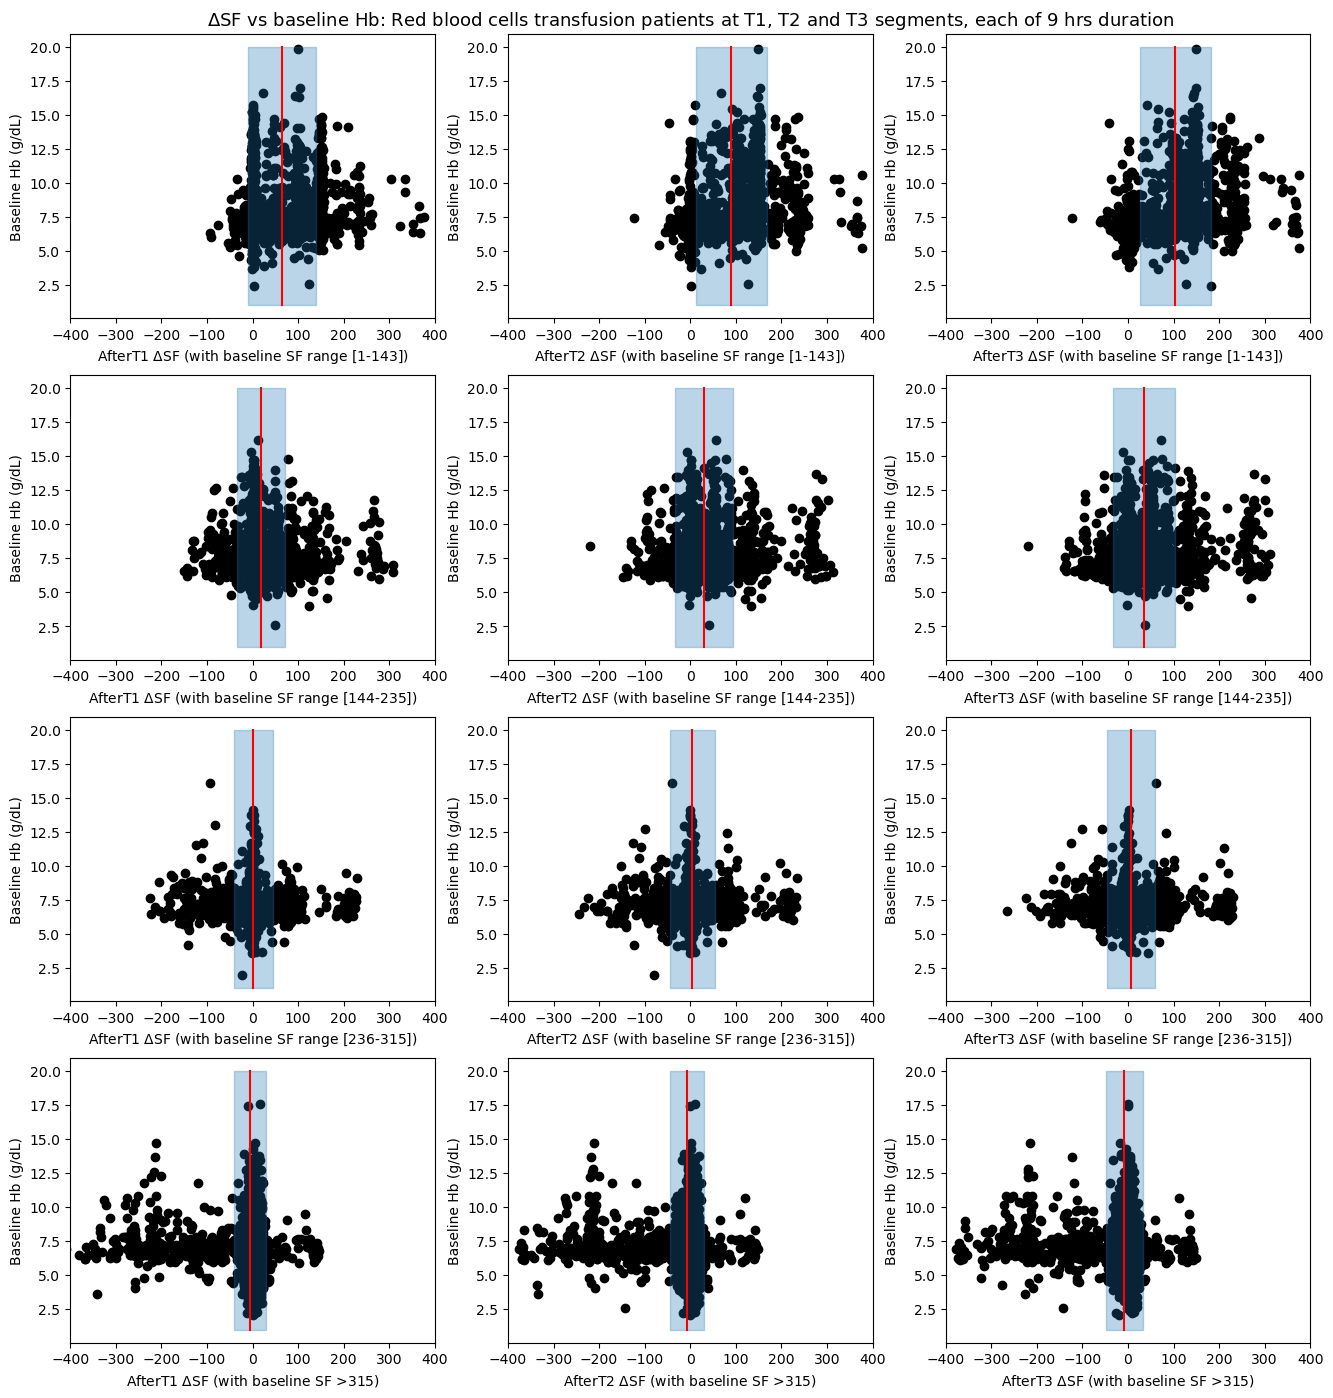

In [51]:
fig, axs = plt.subplots(4, 3, figsize =(16, 17))
line1 = np.arange(1,21)

axs[0,0].scatter(df_transf['del_SF_1a'], df_transf['Hb'],color='black')
#axs[0,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [1-143])')
axs[0,0].set_ylabel('Baseline Hb (g/dL)')
axs[0,0].set_xlim([-400, 400])
# axs[0,0].set_ylim([df_transf['Hb'].min()-0.5, df_transf['Hb'].max()+0.5])
axs[0,0].plot(np.nanmean(dSF1a)*np.ones(20), line1,color='red')
axs[0,0].fill_betweenx(line1, m_s_1a[0], m_s_1a[1], color='C0', alpha=0.3)


axs[0,1].scatter(df_transf['del_SF_2a'], df_transf['Hb'],color='black')
axs[0,1].set_title('$\Delta$SF vs baseline Hb: Red blood cells transfusion patients at T1, T2 and T3 segments, each of 9 hrs duration', fontsize = 13)#\u03C4=9hrs
axs[0,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [1-143])')
axs[0,1].set_ylabel('Baseline Hb (g/dL)')
axs[0,1].set_xlim([-400, 400])
# axs[0,1].set_ylim([np.min(mHb2a)-0.5, np.max(mHb2a)+0.5])
axs[0,1].plot(np.nanmean(dSF2a)*np.ones(20), line1,color='red')
#axs[0,1].plot(CI2a[0]*np.ones(20), line1,'g:',CI2a[1]*np.ones(20), line1,'g:')
axs[0,1].fill_betweenx(line1, m_s_2a[0], m_s_2a[1], color='C0', alpha=0.3)


axs[0,2].scatter(df_transf['del_SF_3a'], df_transf['Hb'],color='black')
#axs[0,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [1-143])')
axs[0,2].set_ylabel('Baseline Hb (g/dL)')
axs[0,2].set_xlim([-400, 400])
# axs[0,2].set_ylim([np.min(mHb3a)-0.5, np.max(mHb3a)+0.5])
axs[0,2].plot(np.nanmean(dSF3a)*np.ones(20), line1,color='red')
#axs[0,2].plot(CI3a[0]*np.ones(20), line1,'g:',CI3a[1]*np.ones(20), line1,'g:')
axs[0,2].fill_betweenx(line1, m_s_3a[0], m_s_3a[1], color='C0', alpha=0.3)


#----------------------------------------------------------------------------
axs[1,0].scatter(df_transf['del_SF_1b'], df_transf['Hb'],color='black')
#axs[1,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [144-235])')
axs[1,0].set_ylabel('Baseline Hb (g/dL)')
axs[1,0].set_xlim([-400, 400])
# axs[1,0].set_ylim([np.min(mHb1b)-0.5, np.max(mHb1b)+0.5])
axs[1,0].plot(np.nanmean(dSF1b)*np.ones(20), line1,color='red')
axs[1,0].fill_betweenx(line1, m_s_1b[0], m_s_1b[1], color='C0', alpha=0.3)


axs[1,1].scatter(df_transf['del_SF_2b'], df_transf['Hb'],color='black')
#axs[1,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [144-235])')
axs[1,1].set_ylabel('Baseline Hb (g/dL)')
axs[1,1].set_xlim([-400, 400])
# axs[1,1].set_ylim([np.min(mHb2b)-0.5, np.max(mHb2b)+0.5])
axs[1,1].plot(np.nanmean(dSF2b)*np.ones(20), line1,color='red')
axs[1,1].fill_betweenx(line1, m_s_2b[0], m_s_2b[1], color='C0', alpha=0.3)


axs[1,2].scatter(df_transf['del_SF_3b'], df_transf['Hb'],color='black')
#axs[1,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [144-235])')
axs[1,2].set_ylabel('Baseline Hb (g/dL)')
axs[1,2].set_xlim([-400, 400])
# axs[1,2].set_ylim([np.min(mHb3b)-0.5, np.max(mHb3b)+0.5])
axs[1,2].plot(np.nanmean(dSF3b)*np.ones(20), line1,color='red')
axs[1,2].fill_betweenx(line1, m_s_3b[0], m_s_3b[1], color='C0', alpha=0.3)

##--------------------------------------------------------------------
axs[2,0].scatter(df_transf['del_SF_1c'], df_transf['Hb'],color='black')
#axs[2,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [236-315])')
axs[2,0].set_ylabel('Baseline Hb (g/dL)')
axs[2,0].set_xlim([-400, 400])
# axs[2,0].set_ylim([np.min(mHb1c)-0.5, np.max(mHb1c)+0.5])
axs[2,0].plot(np.nanmean(dSF1c)*np.ones(20), line1,color='red')
axs[2,0].fill_betweenx(line1, m_s_1c[0], m_s_1c[1], color='C0', alpha=0.3)


axs[2,1].scatter(df_transf['del_SF_2c'], df_transf['Hb'],color='black')
#axs[2,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [236-315])')
axs[2,1].set_ylabel('Baseline Hb (g/dL)')
axs[2,1].set_xlim([-400, 400])
# axs[2,1].set_ylim([np.min(mHb2c)-0.5, np.max(mHb2c)+0.5])
axs[2,1].plot(np.nanmean(dSF2c)*np.ones(20), line1,color='red')
axs[2,1].fill_betweenx(line1, m_s_2c[0], m_s_2c[1], color='C0', alpha=0.3)

axs[2,2].scatter(df_transf['del_SF_3c'], df_transf['Hb'],color='black')
#axs[2,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [236-315])')
axs[2,2].set_ylabel('Baseline Hb (g/dL)')
axs[2,2].set_xlim([-400, 400])
# axs[2,2].set_ylim([np.min(mHb3c)-0.5, np.max(mHb3c)+0.5])
axs[2,2].plot(np.nanmean(dSF3c)*np.ones(20), line1,color='red')
axs[2,2].fill_betweenx(line1, m_s_3c[0], m_s_3c[1], color='C0', alpha=0.3)

##-----------------------------------------------------------------
axs[3,0].scatter(df_transf['del_SF_1d'], df_transf['Hb'],color='black')
#axs[3,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF >315)')
axs[3,0].set_ylabel('Baseline Hb (g/dL)')
axs[3,0].set_xlim([-400, 400])
# axs[3,0].set_ylim([np.min(mHb1d)-0.5, np.max(mHb1d)+0.5])
axs[3,0].plot(np.nanmean(dSF1d)*np.ones(20), line1,color='red')
#axs[3,0].plot(CI1d[0]*np.ones(20), line1,'g:',CI1d[1]*np.ones(20), line1,'g:')
axs[3,0].fill_betweenx(line1, m_s_1d[0], m_s_1d[1], color='C0', alpha=0.3)

axs[3,1].scatter(df_transf['del_SF_2d'], df_transf['Hb'],color='black')
#axs[3,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF >315)')
axs[3,1].set_ylabel('Baseline Hb (g/dL)')
axs[3,1].set_xlim([-400, 400])
# axs[3,1].set_ylim([np.min(mHb2d)-0.5, np.max(mHb2d)+0.5])
axs[3,1].plot(np.nanmean(dSF2d)*np.ones(20), line1,color='red')
#axs[3,1].plot(CI2d[0]*np.ones(20), line1,'g:',CI2d[1]*np.ones(20), line1,'g:')
axs[3,1].fill_betweenx(line1, m_s_2d[0], m_s_2d[1], color='C0', alpha=0.3)

axs[3,2].scatter(df_transf['del_SF_3d'], df_transf['Hb'],color='black')
#axs[3,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF >315)')
axs[3,2].set_ylabel('Baseline Hb (g/dL)')
axs[3,2].set_xlim([-400, 400])
# axs[3,2].set_ylim([np.min(mHb3d)-0.5, np.max(mHb3d)+0.5])
axs[3,2].plot(np.nanmean(dSF3d)*np.ones(20), line1,color='red')
#axs[3,2].plot(CI3d[0]*np.ones(20), line1,'g:',CI3d[1]*np.ones(20), line1,'g:')
axs[3,2].fill_betweenx(line1, m_s_3d[0], m_s_3d[1], color='C0', alpha=0.3)

# plt.savefig('DATA_RESULTS_REV1/delSFvsHb_RedCellsT_withCI.png',format="png", bbox_inches="tight", dpi=300)

Text(0.5, 0.92, '$\\Delta$SF vs baseline Hb: RBC transfusion patients at post-transfusion T1 segment of 9 hrs duration')

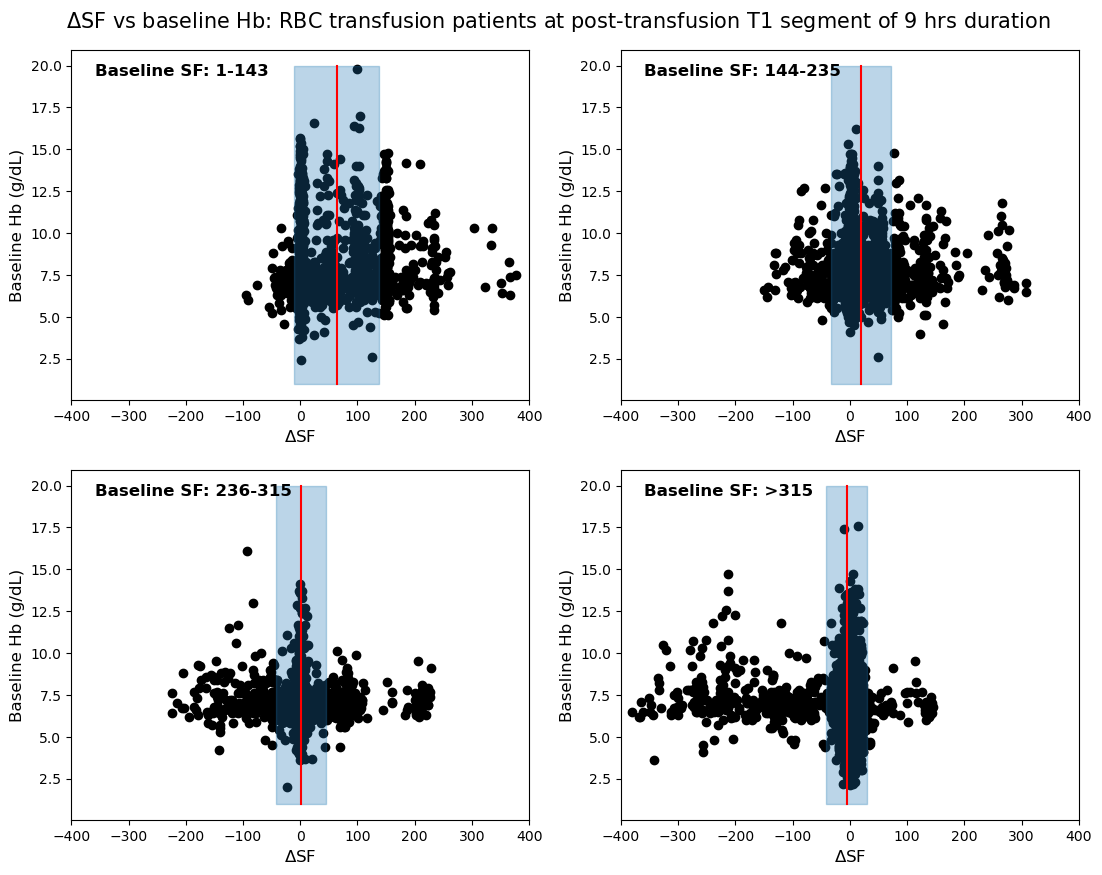

In [52]:
#in 2 x 2 subplots 
fig, axs = plt.subplots(2, 2, figsize =(13, 10))
line1 = np.arange(1,21)

axs[0,0].scatter(df_transf['del_SF_1a'], df_transf['Hb'],color='black')
#axs[0,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('$\Delta$SF', fontsize=12)
axs[0,0].set_ylabel('Baseline Hb (g/dL)', fontsize=12)
axs[0,0].set_xlim([-400, 400])
# axs[0,0].set_ylim([np.min(mHb1a)-0.5, np.max(mHb1a)+0.5])
axs[0,0].plot(np.nanmean(dSF1a)*np.ones(20), line1,color='red')
axs[0,0].fill_betweenx(line1, m_s_1a[0], m_s_1a[1], color='C0', alpha=0.3)



#----------------------------------------------------------------------------
axs[0,1].scatter(df_transf['del_SF_1b'], df_transf['Hb'],color='black')
axs[0,1].set_xlabel('$\Delta$SF', fontsize=12)
axs[0,1].set_ylabel('Baseline Hb (g/dL)', fontsize=12)
axs[0,1].set_xlim([-400, 400])
# axs[0,1].set_ylim([np.min(mHb1b)-0.5, np.max(mHb1b)+0.5])
axs[0,1].plot(np.nanmean(dSF1b)*np.ones(20), line1,color='red')
axs[0,1].fill_betweenx(line1, m_s_1b[0], m_s_1b[1], color='C0', alpha=0.3)

##--------------------------------------------------------------------
axs[1,0].scatter(df_transf['del_SF_1c'], df_transf['Hb'],color='black')
#axs[1,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('$\Delta$SF', fontsize=12)
axs[1,0].set_ylabel('Baseline Hb (g/dL)', fontsize=12)
axs[1,0].set_xlim([-400, 400])
# axs[1,0].set_ylim([np.min(mHb1c)-0.5, np.max(mHb1c)+0.5])
axs[1,0].plot(np.nanmean(dSF1c)*np.ones(20), line1,color='red')
axs[1,0].fill_betweenx(line1, m_s_1c[0], m_s_1c[1], color='C0', alpha=0.3)

##-----------------------------------------------------------------
axs[1,1].scatter(df_transf['del_SF_1d'], df_transf['Hb'],color='black')
#axs[1,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('$\Delta$SF', fontsize=12)
axs[1,1].set_ylabel('Baseline Hb (g/dL)', fontsize=12)
axs[1,1].set_xlim([-400, 400])
# axs[1,1].set_ylim([np.min(mHb1d)-0.5, np.max(mHb1d)+0.5])
axs[1,1].plot(np.nanmean(dSF1d)*np.ones(20), line1,color='red')
#axs[1,1].plot(CI1d[0]*np.ones(20), line1,'g:',CI1d[1]*np.ones(20), line1,'g:')
axs[1,1].fill_betweenx(line1, m_s_1d[0], m_s_1d[1], color='C0', alpha=0.3)


# Show texts
axs[0,0].text(0.051, 0.96, 'Baseline SF: 1-143', horizontalalignment='left', verticalalignment='top', transform=axs[0,0].transAxes, fontsize=12, fontdict=dict(weight='bold'))
axs[0,1].text(0.051, 0.96, 'Baseline SF: 144-235', horizontalalignment='left', verticalalignment='top', transform=axs[0,1].transAxes, fontsize=12, fontdict=dict(weight='bold'))
axs[1,0].text(0.051, 0.96, 'Baseline SF: 236-315', horizontalalignment='left', verticalalignment='top', transform=axs[1,0].transAxes, fontsize=12, fontdict=dict(weight='bold'))
axs[1,1].text(0.051, 0.96, 'Baseline SF: >315', horizontalalignment='left', verticalalignment='top', transform=axs[1,1].transAxes, fontsize=12, fontdict=dict(weight='bold'))


#ax2.text(0.9, 0.5, 'End text', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


plt.suptitle('$\Delta$SF vs baseline Hb: RBC transfusion patients at post-transfusion T1 segment of 9 hrs duration', fontsize = 15, y=0.92)#\u03C4=9hrs
#plt.show()

# plt.savefig('DATA_RESULTS_REV1/delSFvsHb_RedCellsT_withCI_2by2.png',format="png", bbox_inches="tight", dpi=300)

**$\Delta$ SF vs baseline SF**

In [53]:
np.max(MSFbaseline_gp1)+0.5

143.47619047619048

In [54]:
df_transf.columns

Index(['pat_id', 'PAT_ID', 'csn', 'encntr_id', 'dispense_dt_tm',
       'estimated_transfusion_dt_tm', 'product_cd_disp', 'bed_location_start',
       'bed_location_end', 'product_cat_cd_disp', 'orig_volume', 'year',
       'hospital_service', 'Arb', 'Tcount_7d', 'discharge_to', 'age', 'gender',
       'race', 'ethnicity', 'Hb', 'med_spo2_beforeT', 'med_Hb_beforeT',
       'med_SF_beforeT', 'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2',
       'MSPO2_afterT3', 'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3',
       'MSF_afterT1', 'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1',
       'MPF_afterT2', 'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3',
       'del_Hb_1', 'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3',
       'del_PF_1', 'del_PF_2', 'del_PF_3', 'MSF_beforeT', 'del_SF_1a',
       'del_SF_2a', 'del_SF_3a', 'del_SF_1b', 'del_SF_2b', 'del_SF_3b',
       'del_SF_1c', 'del_SF_2c', 'del_SF_3c', 'del_SF_1d', 'del_SF_2d',
       'del_SF_3d'],
      dtype='object')

In [55]:
# MSFbaseline_gp1.isnull().sum()
df_transf['del_SF_2a'].isnull().sum()

21216

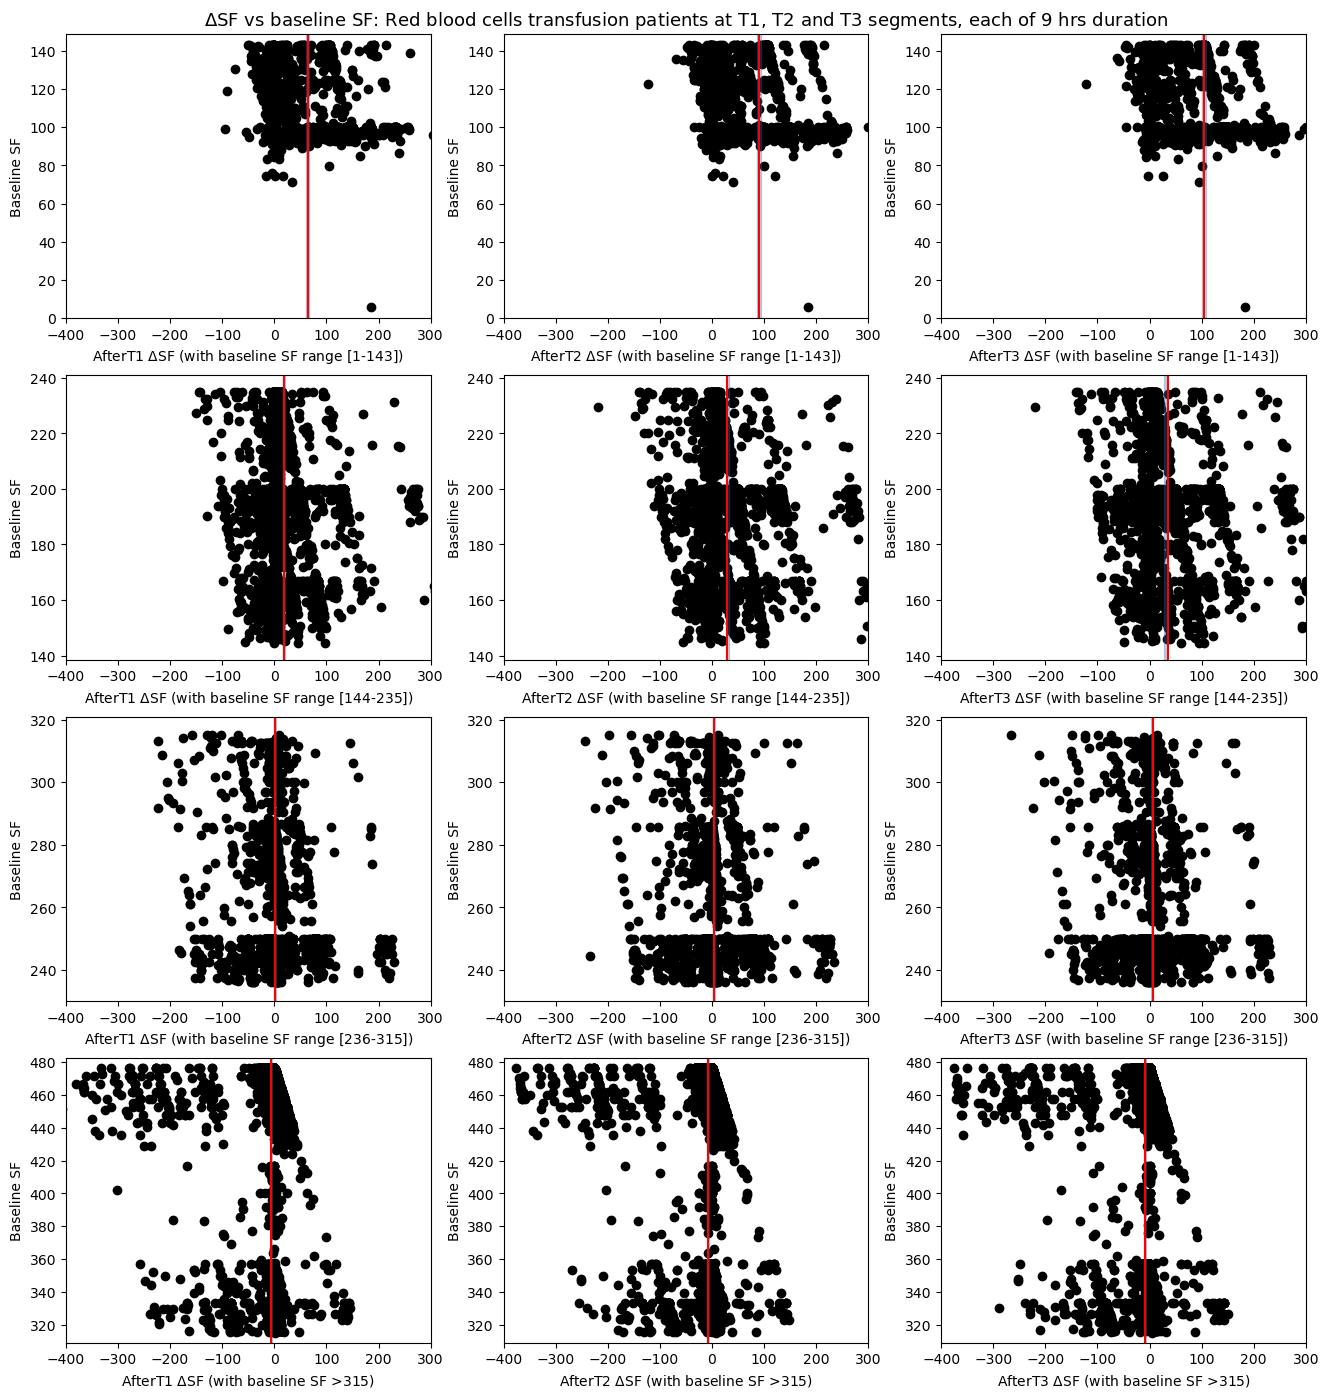

In [56]:
fig, axs = plt.subplots(4, 3, figsize =(16, 17))
line1 = np.arange(500)

axs[0,0].scatter(df_transf['del_SF_1a'], MSFbaseline_gp1,color='black')
#axs[0,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [1-143])')
axs[0,0].set_ylabel('Baseline SF')
axs[0,0].set_xlim([-400, 300])
axs[0,0].set_ylim([np.min(MSFbaseline_gp1)-6, np.max(MSFbaseline_gp1)+6])
axs[0,0].plot(np.mean(dSF1a)*np.ones(500), line1,color='red')
axs[0,0].fill_betweenx(line1, CI1a[0], CI1a[1], color='C0', alpha=0.3)


axs[0,1].scatter(df_transf['del_SF_2a'], MSFbaseline_gp1,color='black')
axs[0,1].set_title('$\Delta$SF vs baseline SF: Red blood cells transfusion patients at T1, T2 and T3 segments, each of 9 hrs duration', fontsize = 13)#\u03C4=9hrs
axs[0,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [1-143])')
axs[0,1].set_ylabel('Baseline SF')
axs[0,1].set_xlim([-400, 300])
axs[0,1].set_ylim([np.min(MSFbaseline_gp1)-6, np.max(MSFbaseline_gp1)+6])
axs[0,1].plot(np.mean(dSF2a)*np.ones(500), line1,color='red')
#axs[0,1].plot(CI2a[0]*np.ones(20), line1,'g:',CI2a[1]*np.ones(20), line1,'g:')
axs[0,1].fill_betweenx(line1, CI2a[0], CI2a[1], color='C0', alpha=0.3)


axs[0,2].scatter(df_transf['del_SF_3a'], MSFbaseline_gp1,color='black')
#axs[0,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [1-143])')
axs[0,2].set_ylabel('Baseline SF')
axs[0,2].set_xlim([-400, 300])
axs[0,2].set_ylim([np.min(MSFbaseline_gp1)-6, np.max(MSFbaseline_gp1)+6])
axs[0,2].plot(np.mean(dSF3a)*np.ones(500), line1,color='red')
#axs[0,2].plot(CI3a[0]*np.ones(20), line1,'g:',CI3a[1]*np.ones(20), line1,'g:')
axs[0,2].fill_betweenx(line1, CI3a[0], CI3a[1], color='C0', alpha=0.3)


#----------------------------------------------------------------------------
axs[1,0].scatter(df_transf['del_SF_1b'], MSFbaseline_gp2,color='black')
#axs[1,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [144-235])')
axs[1,0].set_ylabel('Baseline SF')
axs[1,0].set_xlim([-400, 300])
axs[1,0].set_ylim([np.min(MSFbaseline_gp2)-6, np.max(MSFbaseline_gp2)+6])
axs[1,0].plot(np.mean(dSF1b)*np.ones(500), line1,color='red')
axs[1,0].fill_betweenx(line1, CI1b[0], CI1b[1], color='C0', alpha=0.3)


axs[1,1].scatter(df_transf['del_SF_2b'], MSFbaseline_gp2,color='black')
#axs[1,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [144-235])')
axs[1,1].set_ylabel('Baseline SF')
axs[1,1].set_xlim([-400, 300])
axs[1,1].set_ylim([np.min(MSFbaseline_gp2)-6, np.max(MSFbaseline_gp2)+6])
axs[1,1].plot(np.mean(dSF2b)*np.ones(500), line1,color='red')
axs[1,1].fill_betweenx(line1, CI2b[0], CI2b[1], color='C0', alpha=0.3)


axs[1,2].scatter(df_transf['del_SF_3b'], MSFbaseline_gp2,color='black')
#axs[1,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [144-235])')
axs[1,2].set_ylabel('Baseline SF')
axs[1,2].set_xlim([-400, 300])
axs[1,2].set_ylim([np.min(MSFbaseline_gp2)-6, np.max(MSFbaseline_gp2)+6])
axs[1,2].plot(np.mean(dSF3b)*np.ones(500), line1,color='red')
axs[1,2].fill_betweenx(line1, CI3b[0], CI3b[1], color='C0', alpha=0.3)

##--------------------------------------------------------------------
axs[2,0].scatter(df_transf['del_SF_1c'], MSFbaseline_gp3,color='black')
#axs[2,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF range [236-315])')
axs[2,0].set_ylabel('Baseline SF')
axs[2,0].set_xlim([-400, 300])
axs[2,0].set_ylim([np.min(MSFbaseline_gp3)-6, np.max(MSFbaseline_gp3)+6])
axs[2,0].plot(np.mean(dSF1c)*np.ones(500), line1,color='red')
axs[2,0].fill_betweenx(line1, CI1c[0], CI1c[1], color='C0', alpha=0.3)


axs[2,1].scatter(df_transf['del_SF_2c'], MSFbaseline_gp3,color='black')
#axs[2,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF range [236-315])')
axs[2,1].set_ylabel('Baseline SF')
axs[2,1].set_xlim([-400, 300])
axs[2,1].set_ylim([np.min(MSFbaseline_gp3)-6, np.max(MSFbaseline_gp3)+6])
axs[2,1].plot(np.mean(dSF2c)*np.ones(500), line1,color='red')
axs[2,1].fill_betweenx(line1, CI2c[0], CI2c[1], color='C0', alpha=0.3)

axs[2,2].scatter(df_transf['del_SF_3c'], MSFbaseline_gp3,color='black')
#axs[2,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF range [236-315])')
axs[2,2].set_ylabel('Baseline SF')
axs[2,2].set_xlim([-400, 300])
axs[2,2].set_ylim([np.min(MSFbaseline_gp3)-6, np.max(MSFbaseline_gp3)+6])
axs[2,2].plot(np.mean(dSF3c)*np.ones(500), line1,color='red')
axs[2,2].fill_betweenx(line1, CI3c[0], CI3c[1], color='C0', alpha=0.3)

##-----------------------------------------------------------------
axs[3,0].scatter(df_transf['del_SF_1d'], MSFbaseline_gp4,color='black')
#axs[3,0].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,0].set_xlabel('AfterT1 $\Delta$SF (with baseline SF >315)')
axs[3,0].set_ylabel('Baseline SF')
axs[3,0].set_xlim([-400, 300])
axs[3,0].set_ylim([np.min(MSFbaseline_gp4)-6, np.max(MSFbaseline_gp4)+6])
axs[3,0].plot(np.mean(dSF1d)*np.ones(500), line1,color='red')
#axs[3,0].plot(CI1d[0]*np.ones(20), line1,'g:',CI1d[1]*np.ones(20), line1,'g:')
axs[3,0].fill_betweenx(line1, CI1d[0], CI1d[1], color='C0', alpha=0.3)

axs[3,1].scatter(df_transf['del_SF_2d'], MSFbaseline_gp4,color='black')
#axs[3,1].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,1].set_xlabel('AfterT2 $\Delta$SF (with baseline SF >315)')
axs[3,1].set_ylabel('Baseline SF')
axs[3,1].set_xlim([-400, 300])
axs[3,1].set_ylim([np.min(MSFbaseline_gp4)-6, np.max(MSFbaseline_gp4)+6])
axs[3,1].plot(np.mean(dSF2d)*np.ones(500), line1,color='red')
#axs[3,1].plot(CI2d[0]*np.ones(20), line1,'g:',CI2d[1]*np.ones(20), line1,'g:')
axs[3,1].fill_betweenx(line1, CI2d[0], CI2d[1], color='C0', alpha=0.3)

axs[3,2].scatter(df_transf['del_SF_3d'], MSFbaseline_gp4,color='black')
#axs[3,2].set_title('$\Delta$SF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[3,2].set_xlabel('AfterT3 $\Delta$SF (with baseline SF >315)')
axs[3,2].set_ylabel('Baseline SF')
axs[3,2].set_xlim([-400, 300])
axs[3,2].set_ylim([np.min(MSFbaseline_gp4)-6, np.max(MSFbaseline_gp4)+6])
axs[3,2].plot(np.mean(dSF3d)*np.ones(500), line1,color='red')
#axs[3,2].plot(CI3d[0]*np.ones(20), line1,'g:',CI3d[1]*np.ones(20), line1,'g:')
axs[3,2].fill_betweenx(line1, CI3d[0], CI3d[1], color='C0', alpha=0.3)

# plt.savefig('DATA_RESULTS_REV1/delSFvsBSF_RedCellsT_withCI.png',format="png", bbox_inches="tight", dpi=300)


In [57]:
np.shape(dSF1b), np.shape(MSFbaseline_gp2)

((2459,), (22867,))

## Relation establishment: Baseline SF and RBC.T. efficacy (Delta SF)

In [58]:
from scipy.optimize import curve_fit

In [59]:
def func(x, a, b, c, d):
    return (a*(x)**3) + (b*(x)**2) + (c*(x)) + d

In [104]:
# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c

In [70]:
# xdata = [100, 200, 300, 400]
#xdata = np.append(np.append(np.append(100*np.ones(len(dSF1a)), 200*np.ones(len(dSF1b))), 300*np.ones(len(dSF1c))), 400*np.ones(len(dSF1d))) #Quantized baseline SF 


# BSFa = MSFbaseline_gp1.values #MSFbaseline_gp1[~np.isnan(MSFbaseline_gp1)]
# BSFb = MSFbaseline_gp2.values  #MSFbaseline_gp2[~np.isnan(MSFbaseline_gp2)]
# BSFc = MSFbaseline_gp3.values  #MSFbaseline_gp3[~np.isnan(MSFbaseline_gp3)]
# BSFd = MSFbaseline_gp4.values  #MSFbaseline_gp4[~np.isnan(MSFbaseline_gp4)]
# xdata = np.append(np.append(np.append(BSFa, BSFb), BSFc), BSFd) #consider original/actual baseline SF

In [60]:
xdata = pd.concat([MSFbaseline_gp1,MSFbaseline_gp2,MSFbaseline_gp3,MSFbaseline_gp4])

In [61]:
ydata = pd.concat([df_transf['del_SF_1a'],df_transf['del_SF_1b'],df_transf['del_SF_1c'],df_transf['del_SF_1d']])

In [62]:
# # ydata = [np.mean(dSF1a), np.mean(dSF1b), np.mean(dSF1c), np.mean(dSF1d)]
# # ydata = [np.array(dSF1a), np.array(dSF1b), np.array(dSF1c), np.array(dSF1d)]
# # ydata = np.append([dSF1a1, dSF1b1, dSF1c1], dSF1d1)
# # dSF1a1 = np.transpose(list(dSF1a))
# # dSF1b1 = np.transpose(list(dSF1b))
# # dSF1c1 = np.transpose(list(dSF1c))
# # dSF1d1 = np.transpose(list(dSF1d))

# dSF1a1 = df_transf['del_SF_1a'].values
# dSF1b1 = df_transf['del_SF_1b'].values
# dSF1c1 = df_transf['del_SF_1c'].values
# dSF1d1 = df_transf['del_SF_1d'].values
# ydata = np.append(np.append(np.append(dSF1a1, dSF1b1), dSF1c1), dSF1d1)


In [63]:
xy=pd.concat([xdata, ydata], axis=1)
xy

,0,1
0,None,None
1,None,None
2,None,None
3,None,None
4,None,None
...,...,...
22862,466.666667,0.0
22863,323.75,-171.25
22864,None,NaN
22865,476.190476,0.0


In [64]:
xy2 = xy[~xy.isnull().any(axis=1)]
xy2.reset_index(drop=True, inplace=True)
xy2

,0,1
0,94.666667,-0.166667
1,96.0,236.222222
2,92.333333,155.166667
3,99.0,0.5
4,99.0,107.666667
...,...,...
17263,447.619048,23.809524
17264,466.666667,0.0
17265,323.75,-171.25
17266,476.190476,0.0


In [65]:
np.sum(xy2[0]>10) #Just to avoid outliers

17267

In [66]:
xy2 = xy2[xy2[0]>10] #Just to avoid outliers

In [67]:
xy2.sort_values(by=[0], inplace=True)

/var/folders/fl/fpg3wpyx2kl9_skm4xg51z3h0000gn/T/ipykernel_3542/3030813068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xy2.sort_values(by=[0], inplace=True)


In [68]:
xy2

,0,1
776,71.5,33.763158
139,74.25,-15.25
628,74.5,0.9
757,74.666667,17.333333
1615,76.0,-4.0
...,...,...
15642,476.190476,0.0
8302,476.190476,-9.52381
13049,476.190476,0.0
9933,476.190476,-14.285714


In [69]:
xy2[0].min(), xy2[0].max()

(71.5, 476.1904761904762)

In [70]:
xdata_new = xy2.iloc[:,0].values
ydata_new = xy2.iloc[:,1].values

In [71]:
popt, pcov = curve_fit(func, xdata_new, ydata_new)

In [72]:
popt

array([-2.34455837e-06,  3.02901716e-03, -1.27408269e+00,  1.67902706e+02])

In [73]:
pcov

array([[ 1.14546974e-13, -9.77960626e-11,  2.44553282e-08,
        -1.73869928e-06],
       [-9.77960626e-11,  8.42634651e-08, -2.13601816e-05,
         1.54539223e-03],
       [ 2.44553282e-08, -2.13601816e-05,  5.52870222e-03,
        -4.11577100e-01],
       [-1.73869928e-06,  1.54539223e-03, -4.11577100e-01,
         3.21022620e+01]])

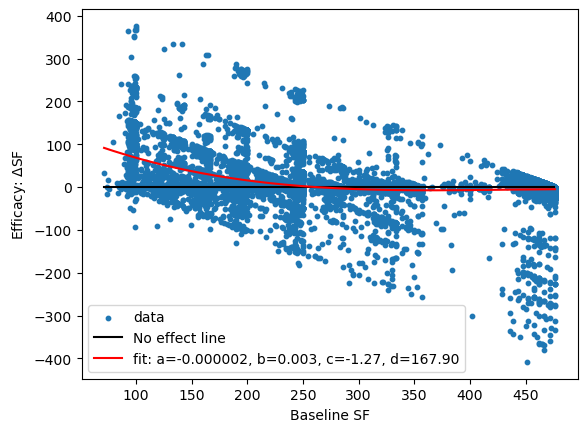

In [74]:
plt.scatter(xdata_new, ydata_new, label='data', s=10)
ll = np.arange(xdata_new.min(), xdata_new.max())
plt.plot(ll, np.zeros(len(ll)), color='k', label='No effect line')
plt.plot(xdata_new, func(xdata_new, *popt), 'r-',label='fit: a=%5.6f, b=%5.3f, c=%5.2f, d=%5.2f' % tuple(popt))
plt.xlabel('Baseline SF')
plt.ylabel('Efficacy: $\Delta$SF')


plt.legend()
# plt.xlim([0,500])
# plt.ylim([-500,500])
plt.show()

Text(0, 0.5, 'Efficacy: $\\Delta$SF')

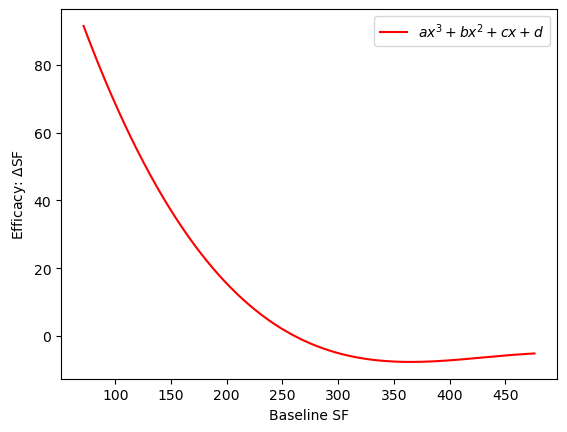

In [75]:
plt.plot(xdata_new, func(xdata_new, *popt), 'r-',label='$ax^3 + bx^2 + cx + d$' )
plt.legend()
plt.xlabel('Baseline SF')
plt.ylabel('Efficacy: $\Delta$SF')

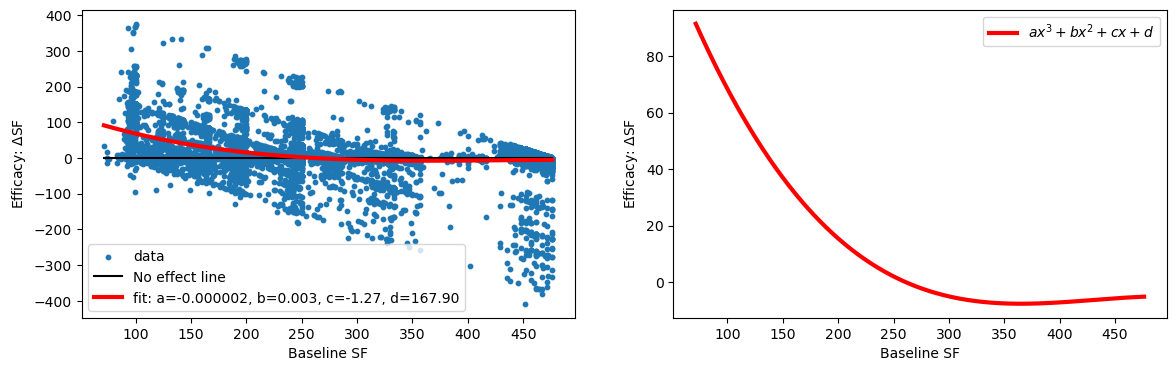

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.scatter(xdata_new, ydata_new, label='data', s=10)
ll = np.arange(xdata_new.min(), xdata_new.max())
ax1.plot(ll, np.zeros(len(ll)), color='k', label='No effect line')
ax1.plot(xdata_new, func(xdata_new, *popt), 'r-',label='fit: a=%5.6f, b=%5.3f, c=%5.2f, d=%5.2f' % tuple(popt), lw=3)
ax1.set_xlabel('Baseline SF')
ax1.set_ylabel('Efficacy: $\Delta$SF')
ax1.legend()

ax2.plot(xdata_new, func(xdata_new, *popt), 'r-',label='$ax^3 + bx^2 + cx + d$' , lw=3)
ax2.legend()
ax2.set_xlabel('Baseline SF')
ax2.set_ylabel('Efficacy: $\Delta$SF')

# plt.xlim([0,500])
# plt.ylim([-500,500])
plt.show()

In [77]:
import sklearn
print('R2 square : ',sklearn.metrics.r2_score(ydata_new, func(xdata_new, *popt)))

R2 square :  0.19004247972047927


In [78]:
xdata_new = np.asarray(xdata_new,  dtype=float)
ydata_new = np.asarray(ydata_new,  dtype=float)

# Storing Emory baseline SF and del SF pairs

In [99]:
xy = np.transpose(np.vstack((xdata_new, ydata_new)))

In [ ]:
# np.save('DATA_RESULTS_REV1/emory_baselineSF_delSF.npy', xy)

# Polynoial curve fitting

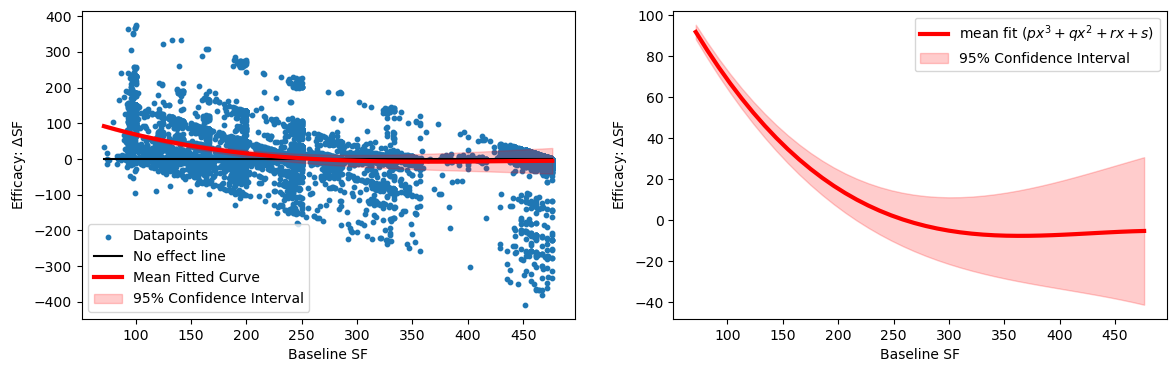

Mean coefficients of the fitted polynomial: [-2.39541682e-06  3.07660991e-03 -1.28789365e+00  1.69162522e+02]
95% confidence intervals of the fitted polynomial coefficients: (array([-2.47462098e-06,  3.00501844e-03, -1.30780342e+00,  1.67450738e+02]), array([-2.31621267e-06,  3.14820137e-03, -1.26798389e+00,  1.70874306e+02]))
R2 square :  0.1900388663214324


In [110]:
def bootstrap_polyfit(x, y, n_bootstrap=50):
    # Number of bootstrap samples: n_bootstrap 
    # Store the polynomial coefficients for each bootstrap sample
    bootstrap_coefficients = []

    # Perform bootstrap sampling
    for _ in range(n_bootstrap):
        # Randomly select 80% of the samples with replacement
        indices = np.random.choice(len(x), size=int(0.8 * len(x)), replace=True)
        x_sample = x[indices]
        y_sample = y[indices]
        
        # Perform polynomial curve fitting with degree 3 (quadratic)
        coefficients = np.polyfit(x_sample, y_sample, 3)
        bootstrap_coefficients.append(coefficients)

    # Convert to numpy array for easier manipulation
    bootstrap_coefficients = np.array(bootstrap_coefficients)

    # Calculate the mean and 95% confidence intervals for the polynomial coefficients
    mean_coefficients = np.mean(bootstrap_coefficients, axis=0)
    # conf_intervals = np.percentile(bootstrap_coefficients, [2.5, 97.5], axis=0)

    #stderr_coefficients = np.std(bootstrap_coefficients, axis=0, ddof=1) / np.sqrt(n_bootstrap)
    conf_intervals = st.t.interval(0.95, n_bootstrap-1, loc=mean_coefficients, scale=st.sem(bootstrap_coefficients, nan_policy='omit')) #stderr_coefficients)

    # Generate polynomial function from mean coefficients
    mean_polynomial = np.poly1d(mean_coefficients)

    # Generate x values for plotting the fitted curve
    x_fit = np.linspace(min(x), max(x), 40)
    y_fit_mean = mean_polynomial(x_fit)

    # Calculate the confidence intervals for the fitted curve
    y_fit_lower = np.poly1d(conf_intervals[0])(x_fit)
    y_fit_upper = np.poly1d(conf_intervals[1])(x_fit)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    ax1.scatter(x, y, label='Datapoints', s=10)
    ll = np.arange(x.min(), x.max())
    ax1.plot(ll, np.zeros(len(ll)), color='k', label='No effect line')
    ax1.plot(x_fit, y_fit_mean, label='Mean Fitted Curve', color='red', lw=3)
    ax1.fill_between(x_fit, y_fit_lower, y_fit_upper, color='red', alpha=0.2, label='95% Confidence Interval')
    ax1.set_xlabel('Baseline SF')
    ax1.set_ylabel('Efficacy: $\Delta$SF')
    ax1.legend()

    ax2.plot(x_fit, y_fit_mean, 'r-',label='mean fit ($px^3 + qx^2 + rx + s$)' , lw=3)
    ax2.fill_between(x_fit, y_fit_lower, y_fit_upper, color='red', alpha=0.2, label='95% Confidence Interval')
    ax2.legend()
    ax2.set_xlabel('Baseline SF')
    ax2.set_ylabel('Efficacy: $\Delta$SF')

    # plt.xlim([0,500])
    # plt.ylim([-500,500])
    plt.show()

    # Print the mean coefficients and confidence intervals of the fitted polynomial
    print("Mean coefficients of the fitted polynomial:", mean_coefficients)
    print("95% confidence intervals of the fitted polynomial coefficients:", conf_intervals)
    return mean_coefficients



# xxxxx = np.linspace(1, 100, 100)
# yyyyy = xxxxx**2 + np.random.normal(scale=150, size=100) # Example: y = x^2
# bootstrap_polyfit(xxxxx, yyyyy, n_bootstrap=100)
mean_coefficients = bootstrap_polyfit(xdata_new, ydata_new, n_bootstrap=100)
print('R2 square : ',sklearn.metrics.r2_score(ydata_new, np.poly1d(mean_coefficients)(xdata_new)))

In [109]:
np.round(np.array([-2.39645172e-06,  3.07141933e-03, -1.28380462e+00,  1.68497983e+02]), 2)

array([ -0.  ,   0.  ,  -1.28, 168.5 ])

In [ ]:
import sklearn


R2 square :  0.19004100218506048


# Random Forest Regressor

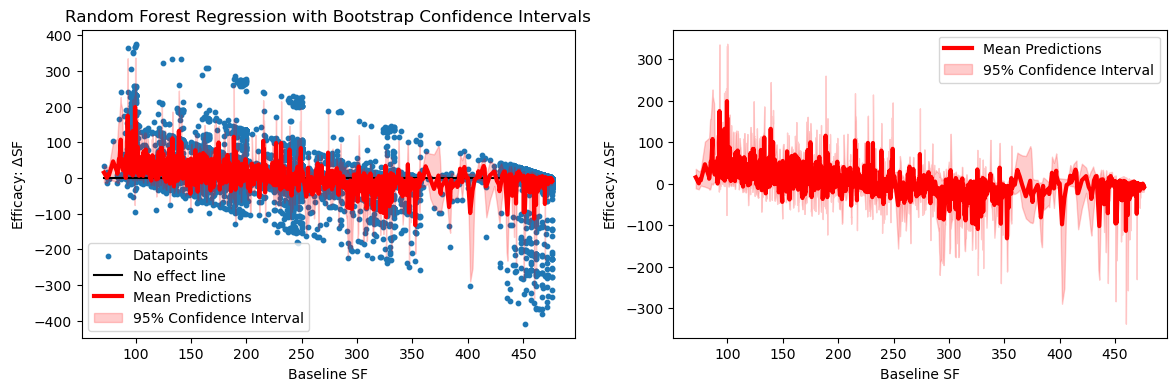

Mean predictions of the fitted curve: [15.10224491  0.4640528   6.6629328  ... -7.09110977 -7.09110977
 -7.09110977]
95% confidence intervals of the fitted curve: [[-11.59120298 -13.91013092 -11.13143092 ...  -8.36107153  -8.36107153
   -8.36107153]
 [ 35.48707641  29.6148938   29.6148938  ...  -5.90785647  -5.90785647
   -5.90785647]]
R2 square :  0.2976348433790885


In [97]:
from sklearn.ensemble import RandomForestRegressor

def bootstrap_RFR(x, y, n_bootstrap=50):
    # Reshape x for the regressor
    x = x.reshape(-1, 1)

    # Store the predictions for each bootstrap sample
    bootstrap_predictions = []

    # Perform bootstrap sampling
    for _ in range(n_bootstrap):
        # Randomly select 80% of the samples with replacement
        indices = np.random.choice(len(x), size=int(0.8 * len(x)), replace=True)
        x_sample = x[indices]
        y_sample = y[indices]
        
        # Create and train the random forest regressor
        rf = RandomForestRegressor(n_estimators=100)
        rf.fit(x_sample, y_sample)
        
        # Predict on the full x range
        y_pred = rf.predict(x)
        bootstrap_predictions.append(y_pred)

    # Convert to numpy array for easier manipulation
    bootstrap_predictions = np.array(bootstrap_predictions)

    # Calculate the mean and 95% confidence intervals for the predictions
    mean_predictions = np.mean(bootstrap_predictions, axis=0)
    conf_intervals = np.percentile(bootstrap_predictions, [2.5, 97.5], axis=0)

    # # Plot the original data points and the mean fitted curve with confidence intervals
    # plt.scatter(x, y, label='Data Points')
    # plt.plot(x, mean_predictions, label='Mean Fitted Curve', color='red')
    # plt.fill_between(x.flatten(), conf_intervals[0], conf_intervals[1], color='red', alpha=0.2, label='95% Confidence Interval')
    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.legend()
    # plt.title('Random Forest Regression with Bootstrap Confidence Intervals')
    # plt.show()


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    ax1.scatter(x, y, label='Datapoints', s=10)
    ll = np.arange(x.min(), x.max())
    ax1.plot(ll, np.zeros(len(ll)), color='k', label='No effect line')
    ax1.plot(x, mean_predictions, label='Mean Predictions', color='red', lw=3)
    ax1.fill_between(x.flatten(), conf_intervals[0], conf_intervals[1], color='red', alpha=0.2, label='95% Confidence Interval')
    ax1.set_xlabel('Baseline SF')
    ax1.set_ylabel('Efficacy: $\Delta$SF')
    ax1.legend()
    ax1.set_title('Random Forest Regression with Bootstrap Confidence Intervals')

    ax2.plot(x, mean_predictions, 'r-',label='Mean Predictions', lw=3)
    ax2.fill_between(x.flatten(), conf_intervals[0], conf_intervals[1], color='red', alpha=0.2, label='95% Confidence Interval')
    ax2.legend()
    ax2.set_xlabel('Baseline SF')
    ax2.set_ylabel('Efficacy: $\Delta$SF')
    plt.show()

    # Print the mean predictions and confidence intervals of the fitted curve
    print("Mean predictions of the fitted curve:", mean_predictions)
    print("95% confidence intervals of the fitted curve:", conf_intervals)
    return mean_predictions


# xxxxx = np.linspace(1, 100, 100)
# yyyyy = xxxxx**2 + np.random.normal(scale=150, size=100) # Example: y = x^2
# bootstrap_polyfit(xxxxx, yyyyy, n_bootstrap=100)
mean_predictions = bootstrap_RFR(xdata_new, ydata_new, n_bootstrap=100)
print('R2 square : ',sklearn.metrics.r2_score(ydata_new, mean_predictions))

### Next Method

In [87]:
# pip install statsmodels

R2 square :  0.16703593963868513


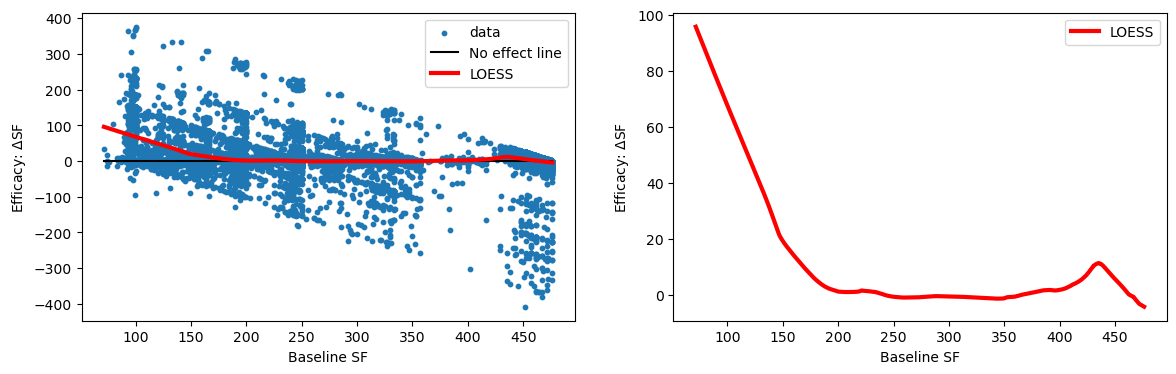

In [95]:
from statsmodels.nonparametric.smoothers_lowess import lowess

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.scatter(xdata_new, ydata_new, label='data', s=10)
ll = np.arange(xdata_new.min(), xdata_new.max())
ax1.plot(ll, np.zeros(len(ll)), color='k', label='No effect line')


filtered = lowess(ydata_new, xdata_new, frac=0.21) #frac=0.15
ax1.plot(filtered[:, 0], filtered[:, 1], 'r-',label='LOESS', lw=3)
ax1.set_xlabel('Baseline SF')
ax1.set_ylabel('Efficacy: $\Delta$SF')
ax1.legend()



ax2.plot(filtered[:, 0], filtered[:, 1], 'r-',label='LOESS', lw=3)
ax2.legend()
ax2.set_xlabel('Baseline SF')
ax2.set_ylabel('Efficacy: $\Delta$SF')

print('R2 square : ', sklearn.metrics.r2_score(ydata_new, filtered[:, 1]))
# # plt.xlim([0,500])
# # plt.ylim([-500,500])
plt.show()

In [96]:
print('R2 square : ',sklearn.metrics.r2_score(ydata_new, filtered[:, 1]))

R2 square :  0.16703593963868513


In [97]:
np.arange(0.01,0.3, 0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29])

In [98]:
z = np.polyfit(list(xdata_new), list(ydata_new), 3)
p = np.poly1d(z)
z

array([-2.34455711e-06,  3.02901608e-03, -1.27408242e+00,  1.67902687e+02])

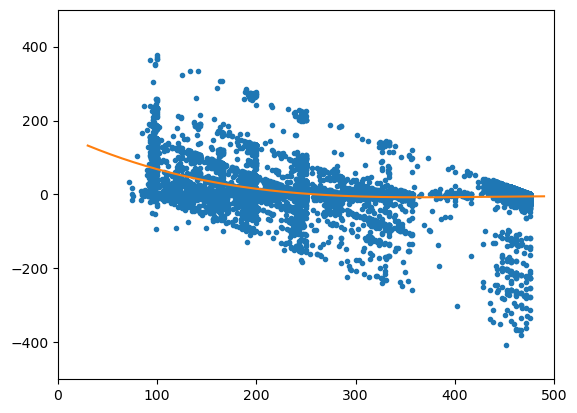

In [99]:
xp = np.linspace(30, 490, 200)
plt.plot(xdata_new, ydata_new, '.', xp, p(xp), '-')
plt.xlim([0,500])
plt.ylim([-500,500])
plt.show()

In [100]:
#define function to calculate adjusted r-squared
def adjR(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))
    return results

In [101]:
adjR(list(xdata_new), list(ydata_new), 1)

{'r_squared': 0.12332541192867674}

**Modification/Postprocessing of ydata (i.e. $\Delta$SF)** 

For same baseline SFs, find mean of $\Delta$SFs. xdata: baseline SF, ydata: $\Delta$SF

In [102]:
xdata

0              None
1              None
2              None
3              None
4              None
            ...    
22862    466.666667
22863        323.75
22864          None
22865    476.190476
22866         350.0
Length: 91468, dtype: object

In [103]:
x=[1, 5, 3, 9, 5, 3, 2, 5]
y=[100, 120, 140, 100, 400, 200, 250, 300]

In [104]:
data = {'x1':xdata_new, 'y1':ydata_new}

In [105]:
df1=pd.DataFrame(data)
df1

,x1,y1
0,71.5,33.763158
1,74.25,-15.25
2,74.5,0.9
3,74.666667,17.333333
4,76.0,-4.0
...,...,...
17262,476.190476,0.0
17263,476.190476,-9.52381
17264,476.190476,0.0
17265,476.190476,-14.285714


In [106]:
df2=df1.sort_values(by=['x1']).reset_index(drop=True)

In [107]:
df2

,x1,y1
0,71.5,33.763158
1,74.25,-15.25
2,74.5,0.9
3,74.666667,17.333333
4,76.0,-4.0
...,...,...
17262,476.190476,0.0
17263,476.190476,0.0
17264,476.190476,0.0
17265,476.190476,-9.52381


In [108]:
xdata_n = np.unique(df2['x1'])
xdata_n

array([71.5, 74.25, 74.5, ..., 475.7936507936508, 475.8928571428572,
       476.1904761904762], dtype=object)

In [109]:
ydata_n = []
for i in xdata_n:
    ids=np.where(df2['x1']==i)
    # print(ids[0])
    mn = np.mean(df2['y1'].iloc[ids[0]])
    ydata_n = np.append(ydata_n, mn)

## TE=a(1/BSF)+b

In [110]:
z = np.polyfit(list(1/xdata_n), ydata_n, 3)
p = np.poly1d(z)
z

array([-1.75490681e+08,  3.22531602e+06, -9.13360767e+03, -6.23074800e+00])

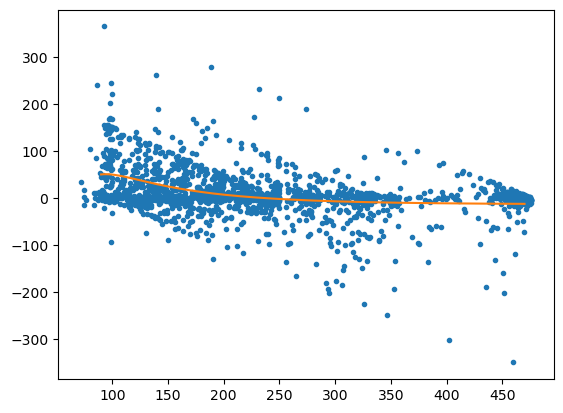

In [111]:
xp = np.linspace(90, 470, 5000)
plt.plot(xdata_n, ydata_n, '.', xp, p(1/xp), '-')
plt.show()

In [112]:
adjR(list(xdata_n), ydata_n, 1)

{'r_squared': 0.11402903839351397}

## Delta PF vs baseline Hb

In [113]:

# df_transf['del_PF_1']=df_transf['MPF_afterT1'] - df_transf['MPF_beforeT']
# df_transf['del_PF_2']=df_transf['MPF_afterT2'] - df_transf['MPF_beforeT']
# df_transf['del_PF_3']=df_transf['MPF_afterT3'] - df_transf['MPF_beforeT']

Text(0, 0.5, 'Baseline Hb (g/dL)')

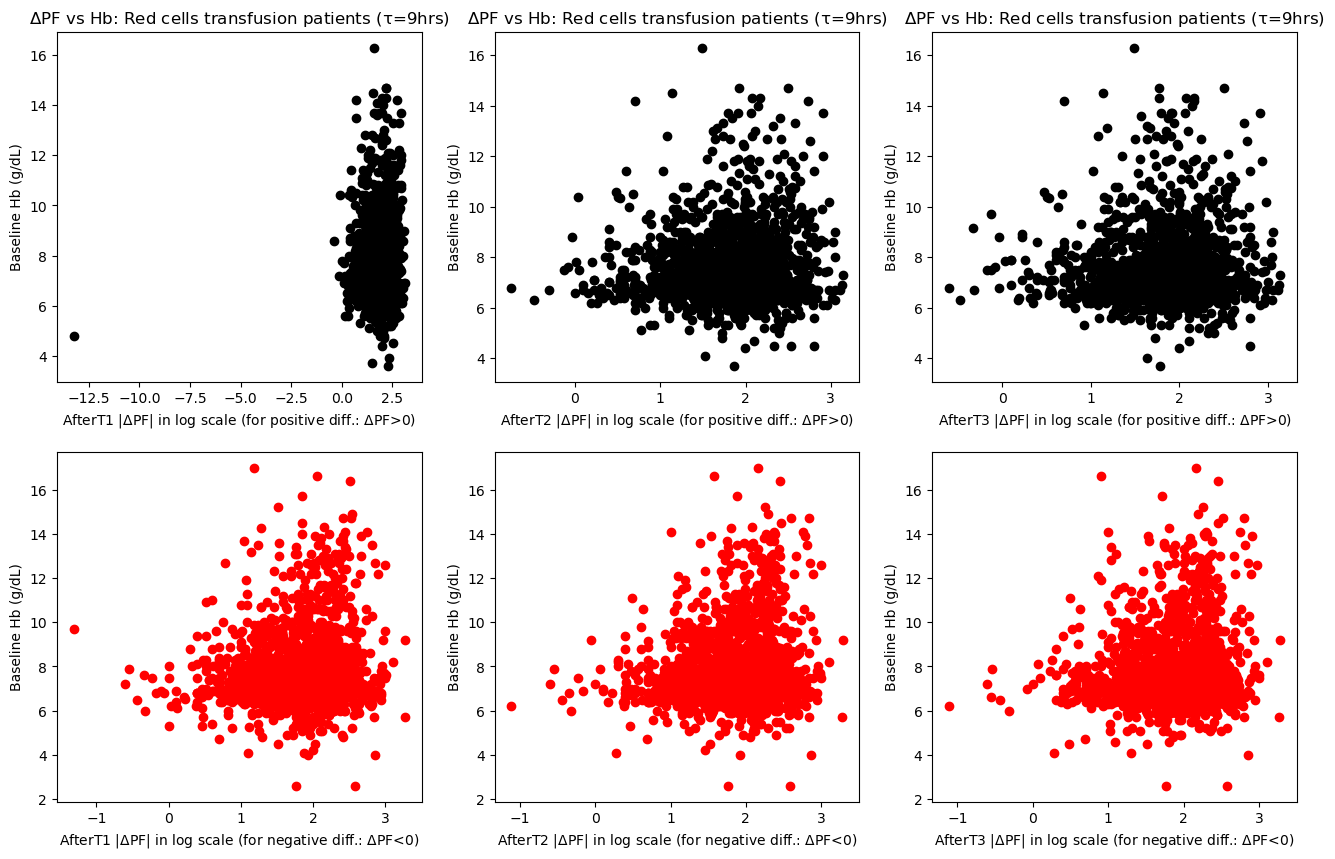

In [114]:
fig, axs = plt.subplots(2, 3, figsize =(16, 10))

delPF1=df_transf['del_PF_1'][df_transf['del_PF_1']>0]
Hb1 = df_transf['Hb'][df_transf['del_PF_1']>0]
axs[0,0].scatter(np.log10(delPF1), Hb1, color='black')
axs[0,0].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,0].set_xlabel('AfterT1 |$\Delta$PF| in log scale (for positive diff.: $\Delta$PF>0)')
axs[0,0].set_ylabel('Baseline Hb (g/dL)')
#axs[0].set_xscale('symlog')#loglog(basex=10)

delPF2=df_transf['del_PF_2'][df_transf['del_PF_2']>0]
Hb2 = df_transf['Hb'][df_transf['del_PF_2']>0]
axs[0,1].scatter(np.log10(delPF2), Hb2,color='black')
axs[0,1].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,1].set_xlabel('AfterT2 |$\Delta$PF| in log scale (for positive diff.: $\Delta$PF>0)')
axs[0,1].set_ylabel('Baseline Hb (g/dL)')
#axs[1].set_xscale('symlog')#loglog(basex=10)

delPF3=df_transf['del_PF_3'][df_transf['del_PF_3']>0]
Hb3 = df_transf['Hb'][df_transf['del_PF_3']>0]
axs[0,2].scatter(np.log10(delPF3), Hb3,color='black')
axs[0,2].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0,2].set_xlabel('AfterT3 |$\Delta$PF| in log scale (for positive diff.: $\Delta$PF>0)')
axs[0,2].set_ylabel('Baseline Hb (g/dL)')
#axs[2].set_xscale('symlog')#loglog(basex=10)

#-------------------
delPF1n=np.abs(df_transf['del_PF_1'][df_transf['del_PF_1']<0])
Hb1n = df_transf['Hb'][df_transf['del_PF_1']<0]
axs[1,0].scatter(np.log10(delPF1n), Hb1n, color='red')
#axs[1,0].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,0].set_xlabel('AfterT1 |$\Delta$PF| in log scale (for negative diff.: $\Delta$PF<0)')
axs[1,0].set_ylabel('Baseline Hb (g/dL)')
#axs[0].set_xscale('symlog')#loglog(basex=10)

delPF2n=np.abs(df_transf['del_PF_2'][df_transf['del_PF_2']<0])
Hb2n = df_transf['Hb'][df_transf['del_PF_2']<0]
axs[1,1].scatter(np.log10(delPF2n), Hb2n,color='red')
#axs[1,1].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,1].set_xlabel('AfterT2 |$\Delta$PF| in log scale (for negative diff.: $\Delta$PF<0)')
axs[1,1].set_ylabel('Baseline Hb (g/dL)')
#axs[1].set_xscale('symlog')#loglog(basex=10)

delPF3n=np.abs(df_transf['del_PF_3'][df_transf['del_PF_3']<0])
Hb3n = df_transf['Hb'][df_transf['del_PF_3']<0]
axs[1,2].scatter(np.log10(delPF3n), Hb3n,color='red')
#axs[1,2].set_title('$\Delta$PF vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1,2].set_xlabel('AfterT3 |$\Delta$PF| in log scale (for negative diff.: $\Delta$PF<0)')
axs[1,2].set_ylabel('Baseline Hb (g/dL)')
#axs[2].set_xscale('symlog')#loglog(basex=10)

# plt.savefig('DATA_RESULTS_REV1/delPFvsHb_RedCellsT_6_23_22_delPF_log.png')

## Find Demographics

In [115]:
df_transf.columns

Index(['pat_id', 'PAT_ID', 'csn', 'encntr_id', 'dispense_dt_tm',
       'estimated_transfusion_dt_tm', 'product_cd_disp', 'bed_location_start',
       'bed_location_end', 'product_cat_cd_disp', 'orig_volume', 'year',
       'hospital_service', 'Arb', 'Tcount_7d', 'discharge_to', 'age', 'gender',
       'race', 'ethnicity', 'Hb', 'med_spo2_beforeT', 'med_Hb_beforeT',
       'med_SF_beforeT', 'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2',
       'MSPO2_afterT3', 'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3',
       'MSF_afterT1', 'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1',
       'MPF_afterT2', 'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3',
       'del_Hb_1', 'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3',
       'del_PF_1', 'del_PF_2', 'del_PF_3', 'MSF_beforeT', 'del_SF_1a',
       'del_SF_2a', 'del_SF_3a', 'del_SF_1b', 'del_SF_2b', 'del_SF_3b',
       'del_SF_1c', 'del_SF_2c', 'del_SF_3c', 'del_SF_1d', 'del_SF_2d',
       'del_SF_3d'],
      dtype='object')

In [116]:
Total_T_instances = len(df_transf)
Total_T_instances

22867

In [117]:
Total_pat_csn = len(np.unique(df_transf['csn']))
Total_pat_csn

14758

In [118]:
csns = df_transf['csn']

In [119]:
df_transf.columns

Index(['pat_id', 'PAT_ID', 'csn', 'encntr_id', 'dispense_dt_tm',
       'estimated_transfusion_dt_tm', 'product_cd_disp', 'bed_location_start',
       'bed_location_end', 'product_cat_cd_disp', 'orig_volume', 'year',
       'hospital_service', 'Arb', 'Tcount_7d', 'discharge_to', 'age', 'gender',
       'race', 'ethnicity', 'Hb', 'med_spo2_beforeT', 'med_Hb_beforeT',
       'med_SF_beforeT', 'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2',
       'MSPO2_afterT3', 'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3',
       'MSF_afterT1', 'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1',
       'MPF_afterT2', 'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3',
       'del_Hb_1', 'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3',
       'del_PF_1', 'del_PF_2', 'del_PF_3', 'MSF_beforeT', 'del_SF_1a',
       'del_SF_2a', 'del_SF_3a', 'del_SF_1b', 'del_SF_2b', 'del_SF_3b',
       'del_SF_1c', 'del_SF_2c', 'del_SF_3c', 'del_SF_1d', 'del_SF_2d',
       'del_SF_3d'],
      dtype='object')

In [115]:
# df_transf['sf_range'] = 

In [114]:
### TABLEONE


## Table One of Demographic and Important Features

In [115]:
# cols = .....


# from tableone import TableOne
# groupby = ['kmean_cluster']
# cols = cols
# categorical=['gender','race','ethnicity']

# ##### limit the binary variable to a single row
# # limit = {"hispanic": 1}
# labels={'kmean_cluster': 'RBC Trnasfusion Phenotypes'}
# data = medianAllSuperTable3new
# phenotypes_unimputed = TableOne(data, missing=False, columns=cols, categorical=categorical, groupby=groupby,rename=labels,label_suffix=True, pval=True, htest_name=True) #, nonnormal=nonnormal) #, limit=limit) 
# #, columns=columns, categorical=categorical, groupby=groupby, nonnormal=nonnormal, rename=labels, pval=False)
# phenotypes_unimputed

# # phenotypes_unimputed.to_latex('tableoneEmory_unimputed_v1g.tex')
# # phenotypes_unimputed.to_csv('tableoneEmory_unimputed_v1g.csv')

In [120]:
df_transf.columns

Index(['pat_id', 'PAT_ID', 'csn', 'encntr_id', 'dispense_dt_tm',
       'estimated_transfusion_dt_tm', 'product_cd_disp', 'bed_location_start',
       'bed_location_end', 'product_cat_cd_disp', 'orig_volume', 'year',
       'hospital_service', 'Arb', 'Tcount_7d', 'discharge_to', 'age', 'gender',
       'race', 'ethnicity', 'Hb', 'med_spo2_beforeT', 'med_Hb_beforeT',
       'med_SF_beforeT', 'med_PF_beforeT', 'MSPO2_afterT1', 'MSPO2_afterT2',
       'MSPO2_afterT3', 'MHB_afterT1', 'MHB_afterT2', 'MHB_afterT3',
       'MSF_afterT1', 'MSF_afterT2', 'MSF_afterT3', 'MPF_afterT1',
       'MPF_afterT2', 'MPF_afterT3', 'del_SPO2_1', 'del_SPO2_2', 'del_SPO2_3',
       'del_Hb_1', 'del_Hb_2', 'del_Hb_3', 'del_SF_1', 'del_SF_2', 'del_SF_3',
       'del_PF_1', 'del_PF_2', 'del_PF_3', 'MSF_beforeT', 'del_SF_1a',
       'del_SF_2a', 'del_SF_3a', 'del_SF_1b', 'del_SF_2b', 'del_SF_3b',
       'del_SF_1c', 'del_SF_2c', 'del_SF_3c', 'del_SF_1d', 'del_SF_2d',
       'del_SF_3d'],
      dtype='object')

In [121]:
df_transf[['csn','year']]

,csn,year
0,15967048,2017
1,16370317,2020
2,17636135,2016
3,20000178,2020
4,22508118,2018
...,...,...
22862,67612800356,2020
22863,67623900358,2020
22864,67629780359,2020
22865,67648980364,2020


In [ ]:
df_transf

## Relation for del SpO2 and del SF

In [ ]:
# del_SF_12 = np.append(df_transf['del_SF_1'], df_transf['del_SF_2'])
# del_SF_all = np.append(del_SF_12, df_transf['del_SF_3'])
# del_SF_all

In [125]:
del_SF_all = pd.concat([df_transf['del_SF_1'], df_transf['del_SF_2'], df_transf['del_SF_3']],axis=0)
del_SF_all.reset_index(drop=True, inplace=True)
del_SF_all.fillna(del_SF_all.median(), inplace=True)
del_SF_all

0         0.000000
1        -2.380952
2         0.000000
3         0.000000
4        87.936508
           ...    
68596     0.000000
68597     0.000000
68598     0.000000
68599     0.000000
68600     0.000000
Length: 68601, dtype: float64

In [126]:
# del_spo2_12 = np.append(df_transf['del_SPO2_1'], df_transf['del_SPO2_2'])
# del_spo2_all = np.append(del_spo2_12, df_transf['del_SPO2_3'])
# del_spo2_all

In [127]:
del_spo2_all = pd.concat([df_transf['del_SPO2_1'], df_transf['del_SPO2_2'], df_transf['del_SPO2_3']],axis=0)
del_spo2_all.reset_index(drop=True, inplace=True)
del_spo2_all.fillna(del_spo2_all.median(), inplace=True)
del_spo2_all

0        0.000000
1       -0.500000
2        0.000000
3        1.000000
4       -1.708333
           ...   
68596    0.000000
68597    0.000000
68598    1.000000
68599    0.000000
68600    0.000000
Length: 68601, dtype: float64

In [128]:
#Normalization (Z-score)
del_SF_allN = (del_SF_all - np.mean(del_SF_all))/np.std(del_SF_all)
del_spo2_allN = (del_spo2_all - np.mean(del_spo2_all))/np.std(del_spo2_all)

# del_SF_allN = (del_SF_all - np.min(del_SF_all))/(np.max(del_SF_all) - np.min(del_SF_all))
# del_spo2_allN = (del_spo2_all - np.min(del_spo2_all))/(np.max(del_spo2_all) - np.min(del_spo2_all))

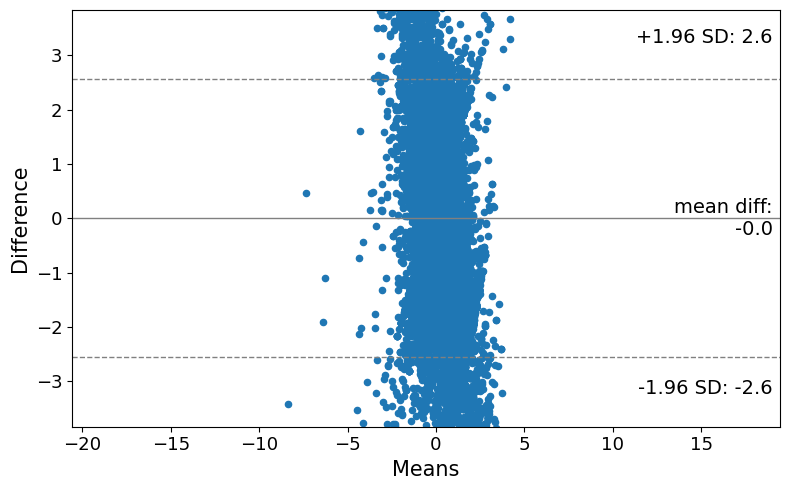

In [129]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(del_spo2_allN, del_SF_allN, ax = ax)

plt.show()

In [130]:
# pip install pyCompare

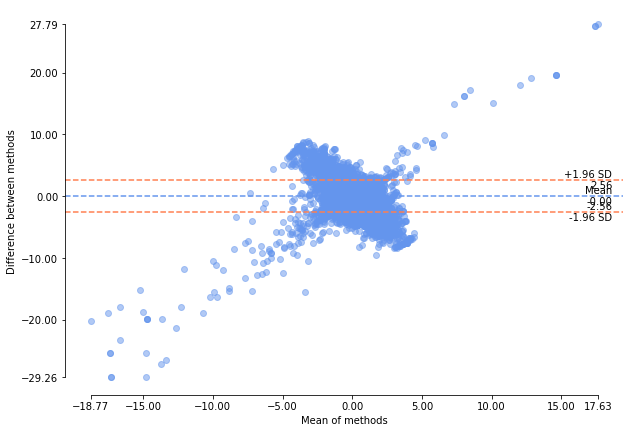

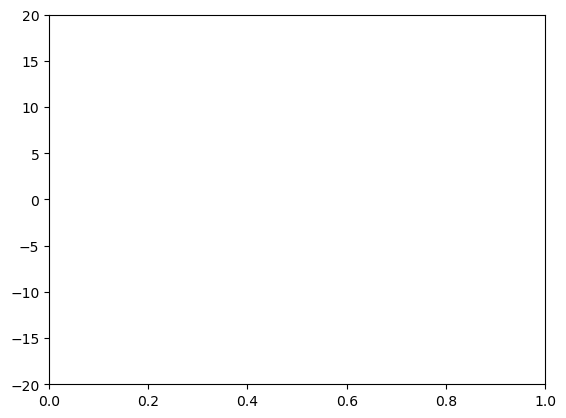

In [131]:
import pyCompare
# pyCompare.blandAltman(del_SF_allN, del_spo2_allN)
plt.Figure()
pyCompare.blandAltman(del_spo2_allN, del_SF_allN)
plt.ylim(-20, 20)
plt.show()

r and p-value are: 0.15020583010364985 0.0


(-20.0, 20.0)

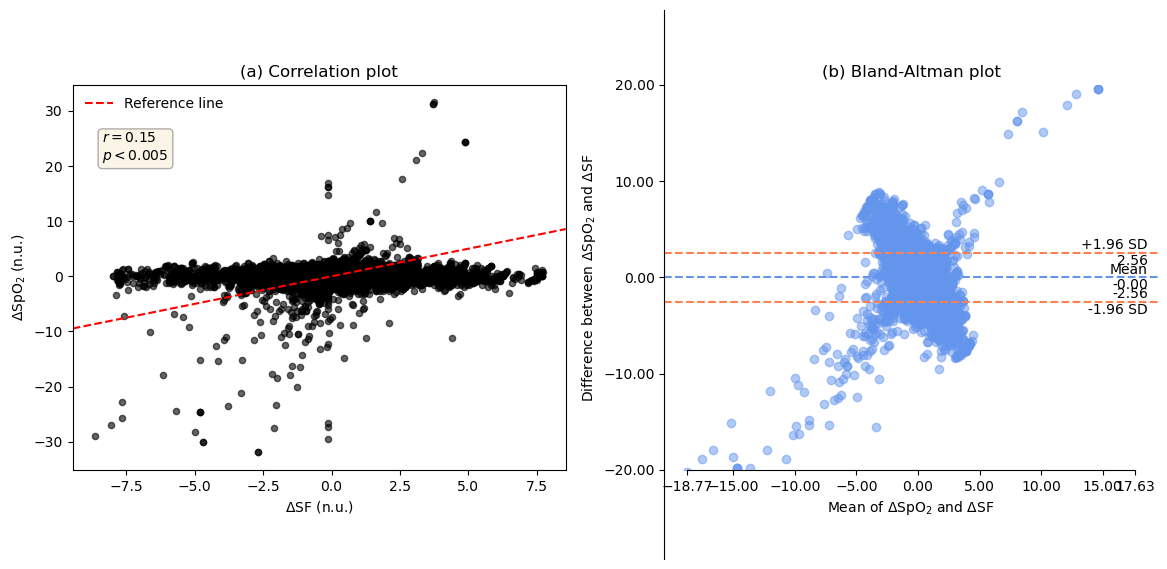

In [132]:
import scipy.stats

fig, axs = plt.subplots(1, 2, figsize =(14, 5))

axs[0].scatter(
     del_SF_allN, del_spo2_allN,
    c='k', s=20, alpha=0.6, marker='o'
)
# Get axis limits
left, right = axs[0].set_xlim()
# Reference line
axs[0].plot([left, right], [left, right], c='r', ls='--', label='Reference line')

r, p = scipy.stats.pearsonr(del_spo2_allN, del_SF_allN)
print(f'r and p-value are:', r, p)

axs[0].legend(frameon=False)
axs[0].set_xlabel('$\Delta$SF (n.u.)')
axs[0].set_ylabel('$\Delta$SpO$_2$ (n.u.)')

textstr = '\n'.join((r'$r=%.2f$' % (r),  r'$p<%.3f$' % (0.005 )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
# place a text box in upper left in axes coords


axs[0].text(0.06, 0.88, textstr, transform=axs[0].transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left', bbox=props)
axs[0].set_title('(a) Correlation plot')

pyCompare.blandAltman(del_spo2_allN, del_SF_allN, ax = axs[1])
axs[1].set_xlabel('Mean of $\Delta$SpO$_2$ and $\Delta$SF')
axs[1].set_ylabel('Difference between $\Delta$SpO$_2$ and $\Delta$SF')
axs[1].set_title('(b) Bland-Altman plot')
axs[1].set_ylim(-20, 20)
# axs[1].set_ylim([-25,16])

# plt.savefig('DATA_RESULTS_REV1/BlandAltmanEmory_delspo2_and_delSF.tif', dpi=300)